In [1]:
%pylab inline
import os,sys,re
import pickle
from copy import deepcopy
from builtins import sum as bsum
from importlib import reload
from collections import defaultdict, namedtuple
from matplotlib.gridspec import GridSpec
import matplotlib.transforms as mtransforms
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)
flush = lambda *args, **kwargs: [sys.stdout.flush(), print(*args, **kwargs)]

Populating the interactive namespace from numpy and matplotlib


In [2]:
os.environ["FISHER_PLUMES"] = os.path.join(os.environ["GIT"],"fisher-plumes")
os.chdir(os.environ["FISHER_PLUMES"])

In [3]:
# Don't reload this, otherwise it will create a new units registry object
# and will then complain about combining different registries.
import units; reload(units); UNITS = units.UNITS; 

In [4]:
import boulder;   reload(boulder)
import crick;     reload(crick)
import surrogate; reload(surrogate)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
import utils; reload(utils); from utils import dict_update, dict_update_from_field
import proc; reload(proc);
FisherPlumes = fp.FisherPlumes
crick.logger.setLevel(logging.DEBUG)
fp.logger.setLevel(logging.INFO)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:crimgrid_w1                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w2                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w3                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w4                                     : y0 - y9 (16 datasets)


INFO:crick:n12T                                            : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12Tslow                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12dishT                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n16T                                            : Y0.440 - Y0.560 (16 datasets)


INFO:crick:n16Tslow                                        : Y0.440 - Y0.560 (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:crimgrid_w1                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w2                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w3                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w4                                     : y0 - y9 (16 datasets)


INFO:crick:n12T                                            : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12Tslow                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12dishT                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n16T                                            : Y0.440 - Y0.560 (16 datasets)


INFO:crick:n16Tslow                                        : Y0.440 - Y0.560 (16 datasets)


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


# Specify the analysis window

In [5]:
window_length = 1 * UNITS.second
windows       = ['boxcar', 'hann', ('kaiser',9), ('kaiser', 16)]
window_shape  = windows[1]
fit_k         = True

# Specify the datasets to use

In [6]:
to_use = {"16Ts":{"sim_name":"n16Tslow"},
          "bw":  {"sim_name":"boulder16"},
          "s=p": {"sim_name":"surr_all_equal"},
          "shw": {"sim_name":"surr_high",      "surrogate_k": 0},          
          "shp": {"sim_name":"surr_high",      "surrogate_k": 4}}

# Load the data

In [7]:
[f.logger.setLevel(logging.WARN) for f in [crick, boulder,fp]];

data =  {k:FisherPlumes(proc.load_data(init_filter = v,
                                       compute_filter = {"window_shape":window_shape,
                                                         "window_length":window_length,
                                                         "fit_k":fit_k}
)[0]) for k,v in to_use.items()}

[f.logger.setLevel(logging.INFO) for f in [crick, boulder,fp]];
    

                    proc 2023/07/11 11:08:35     INFO: Loading init_filter={'sim_name': 'n16Tslow'} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/n16Ts.1/cf342b52bded82e3.p


                    proc 2023/07/11 11:08:40     INFO: Returning 1 results.


                    proc 2023/07/11 11:08:41     INFO: Loading init_filter={'sim_name': 'boulder16'} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/bw.1/7b4445af5cc2f8f3.p


                    proc 2023/07/11 11:08:42     INFO: Returning 1 results.


                    proc 2023/07/11 11:08:42     INFO: Loading init_filter={'sim_name': 'surr_all_equal'} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/su.1/86e02cd4801c9882.p


                    proc 2023/07/11 11:08:43     INFO: Returning 1 results.


INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@or

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@orig

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@orig

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@ori

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@ori

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@ori

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@ori

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@ori

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>}, 'coord_strs': ['@origin'], 'coord_inds': {'@ori

                    proc 2023/07/11 11:08:43     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 0} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.1/5f467e982df9e459.p


                    proc 2023/07/11 11:08:43     INFO: Returning 1 results.


INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-20.99838178],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-20.99838178],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -7.92263259],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -4.45896517],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -2.4916727 ],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-27.87325508],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 13.81625708],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-17.05344673],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -4.62597823],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 32.35989745],
       [-

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[  30.78765427],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 16.24258983],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -4.24927386],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[  9.73885561],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-12.50512481],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-64.27818861],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-50.72101405],
      

                    proc 2023/07/11 11:08:43     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 4} compute_filter={'window_shape': ('kaiser', 16), 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.1/ec088c869bf20a8f.p


                    proc 2023/07/11 11:08:44     INFO: Returning 1 results.


INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-0.84585665],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-0.84585665],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-1.01859563],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-8.25499466],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-5.46857418],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-8.9488669 ],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-13.84395744],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-14.33092166],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-10.39051919],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-13.90236359],
       [-

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-14.94112048],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-13.85379337],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -7.62470057],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-5.76858384],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-7.85668297],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-1.71759623],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-6.95028672],
       

# Whether to save the plots we make and where to put them

In [8]:
SAVEPLOTS = True # Whether to actually make the plots
fig_dir_full        = fpft.get_fig_dir(window_shape = window_shape, window_length = window_length, fit_k = fit_k, create = True); print(f"{fig_dir_full=}")
fig_dir_wnd_shp_len = fpft.get_fig_dir(window_shape = window_shape, window_length = window_length, fit_k = None,  create = True); print(f"{fig_dir_wnd_shp_len=}")
fig_dir_wnd_shp     = fpft.get_fig_dir(window_shape = window_shape, window_length = None,          fit_k = None,  create = True); print(f"{fig_dir_wnd_shp=}")
fig_dir_top         = fpft.get_fig_dir(window_shape = None,         window_length = None,          fit_k = None,  create = True); print(f"{fig_dir_top=}")
fig_dir_fitk        = fpft.get_fig_dir(window_shape = None,         window_length = None,          fit_k = fit_k, create = True); print(f"{fig_dir_fitk=}")

fig_dir_full='figs/kaiser16/1s/fit_k=True'
fig_dir_wnd_shp_len='figs/kaiser16/1s'
fig_dir_wnd_shp='figs/kaiser16'
fig_dir_top='figs'
fig_dir_fitk='figs/fit_k=True'


# Figure showing an example plume and correlations

In [9]:
DEFAULT   = "default"
isdefault = lambda x: type(x) is str and x == DEFAULT

su_ds = [k for k,v in to_use.items() if v["sim_name"].startswith("surr")]
surrQ = lambda x: x in su_ds
print(f"Surrogate datasets = {su_ds}.")

which_srcs   = dict_update_from_field({"bw":[-3750, 3750],
                                       "cr":[490000,510000],
                                       "w1":[107300, 114700], "w2":[218300,225700], "w3":[329300,336700],"w4":[440300,447700],
                                       "12T":[498000,502000], "12Ts":[498000,502000],
                                       "16T":[496000,504000], "16Ts":[496000,504000],
},       
                                      su_ds, "bw")        
t_wnd        = dict_update_from_field({"bw":[-4,4]*UNITS.sec,     "cr":[-0.5, 0.5]*UNITS.sec}, su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts"], "bw")
which_idists = dict_update_from_field({"bw":[0,2,3],              "cr":[0,10,20]},             su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts"], "bw")
tticks       = dict_update_from_field({"bw":DEFAULT,              "cr":[39.5,40,40.5]},        su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts"], "bw")
xticks       = dict_update_from_field({"bw":DEFAULT,              "cr":DEFAULT},               su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts"], "bw")
yticks       = dict_update_from_field({"bw":DEFAULT,              "cr":DEFAULT},               su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts"], "bw")
snapshot_time = defaultdict(lambda: 40000*UNITS.ms, {"12T":10001*UNITS.ms, "12Ts":40010*UNITS.ms,"16T":10001*UNITS.ms, "16Ts":40010*UNITS.ms})

Surrogate datasets = ['s=p', 'shw', 'shp'].


[440000, 448000, 456000, 464000, 472000, 480000, 488000, 496000, 504000, 512000, 520000, 528000, 536000, 544000, 552000, 560000]


      fisher_plumes_figs 2023/07/11 11:08:45     INFO: Clipped snapshots to limsx=array([ 42, 488]), limsy=array([ 33, 405]).


Wrote figs/kaiser16/1s/plumes_demo_16Ts.pdf.


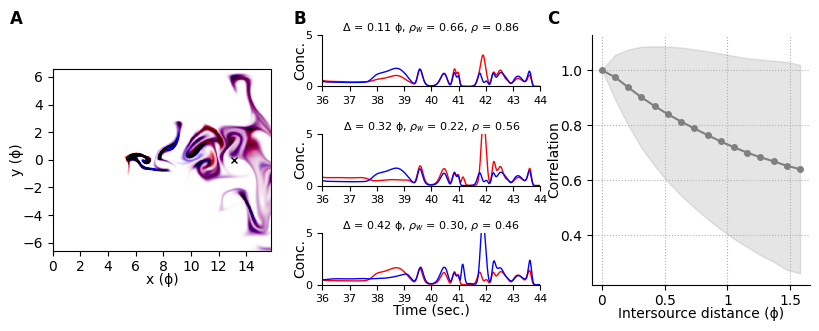

INFO:boulder:Loading fld='c1a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c1a_t40.p'.


INFO:boulder:Loading fld='c1b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c1b_t40.p'.


INFO:boulder:Loading fld='c2a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c2a_t40.p'.


INFO:boulder:Loading fld='c2b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c2b_t40.p'.


INFO:boulder:Loading fld='c3a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c3a_t40.p'.


INFO:boulder:Loading fld='c3b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c3b_t40.p'.


INFO:boulder:Loading fld='c4a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c4a_t40.p'.


INFO:boulder:Loading fld='c4b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c4b_t40.p'.


INFO:boulder:Loading fld='c5a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c5a_t40.p'.


INFO:boulder:Loading fld='c5b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c5b_t40.p'.


INFO:boulder:Loading fld='c6a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c6a_t40.p'.


INFO:boulder:Loading fld='c6b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c6b_t40.p'.


INFO:boulder:Loading fld='c7a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c7a_t40.p'.


INFO:boulder:Loading fld='c7b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c7b_t40.p'.


INFO:boulder:Loading fld='c8a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c8a_t40.p'.


INFO:boulder:Loading fld='c8b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c8b_t40.p'.


Wrote figs/kaiser16/1s/plumes_demo_bw.pdf.


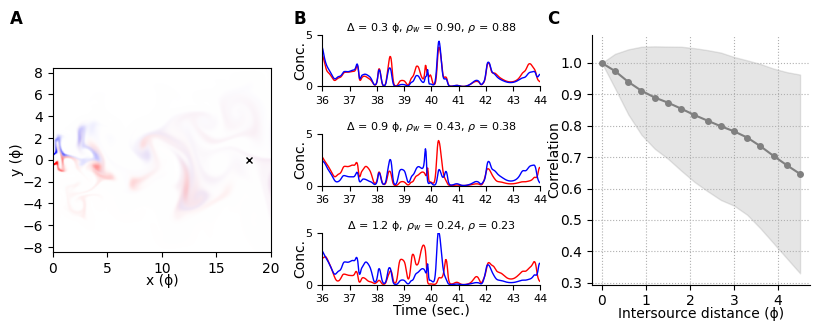

In [10]:
reload(fpf)
reload(fpft)

for k, F in sorted(data.items()):
    if surrQ(k): continue
    ax_plume, ax_traces, ax_corr = fpf.plot_plumes_demo(F, snapshot_time[k], which_srcs[k],
                                                    t_center = (snapshot_time[k].to(UNITS.ms).magnitude//1000)*1000 * UNITS.ms,
                                                    y_lim = (0,5.01) if not surrQ(k) else (-3.01,3.01), y_ticks = [-3,0,3] if surrQ(k) else None,
                                                        data_dir = os.path.join(boulder.data_root, "saved-snapshots") if k == "bw" else None,
                                                    t_wnd = t_wnd[k], dt = 1 * UNITS.sec, which_idists=which_idists[k])
    not isdefault(tticks[k]) and ax_traces[-1].set_xticks(tticks[k])    
    not isdefault(xticks[k]) and ax_plume.set_xticks(xticks[k])
    not isdefault(yticks[k]) and ax_plume.set_yticks(yticks[k])
    if surrQ(k) or k  in ["bw"]: ax_corr.set_xticks(arange(5))
    if surrQ(k): [ax_corr.set_ylim(-0.85,1.05), ax_corr.set_ylabel("Correlation",labelpad=-8)]
    fpft.label_axes([ax_plume, ax_traces[0], ax_corr], "ABC", y = [0.99]*3, fontsize=12, fontweight="bold")
    file_name = f"{fig_dir_wnd_shp_len}/plumes_demo_{k}.pdf"
    #ax_corr.set_ylim(-0.5,1.02)
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Set the probe index we'll use

In [11]:
iprb = 0

# Figure showing the distribution of correlations

16Ts
Mapped frequencies [ 1  2  5 10] Hz to indices [1, 2, 5, 10].


Wrote figs/kaiser16/1s/corr_components_16Ts.pdf.


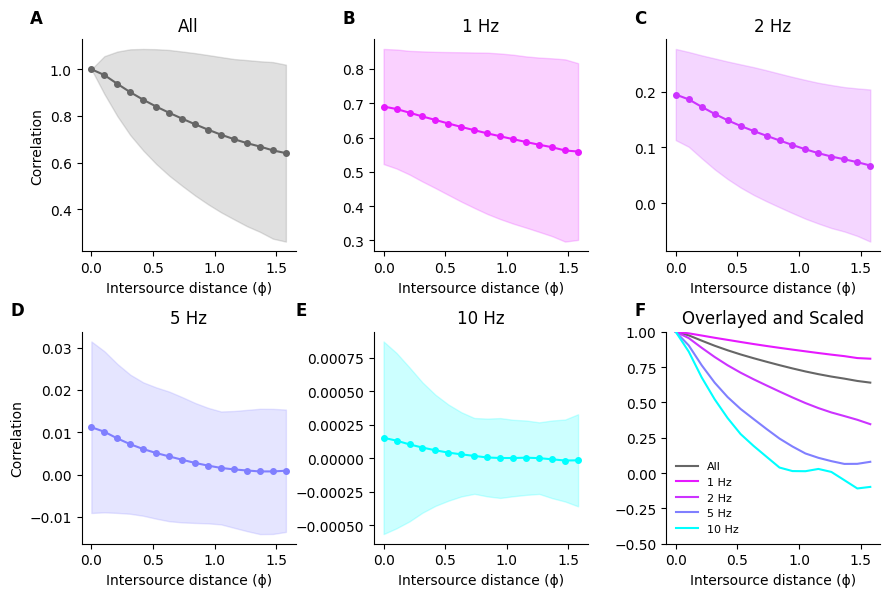

bw
Mapped frequencies [ 1  2  5 10] Hz to indices [1, 2, 5, 10].


Wrote figs/kaiser16/1s/corr_components_bw.pdf.


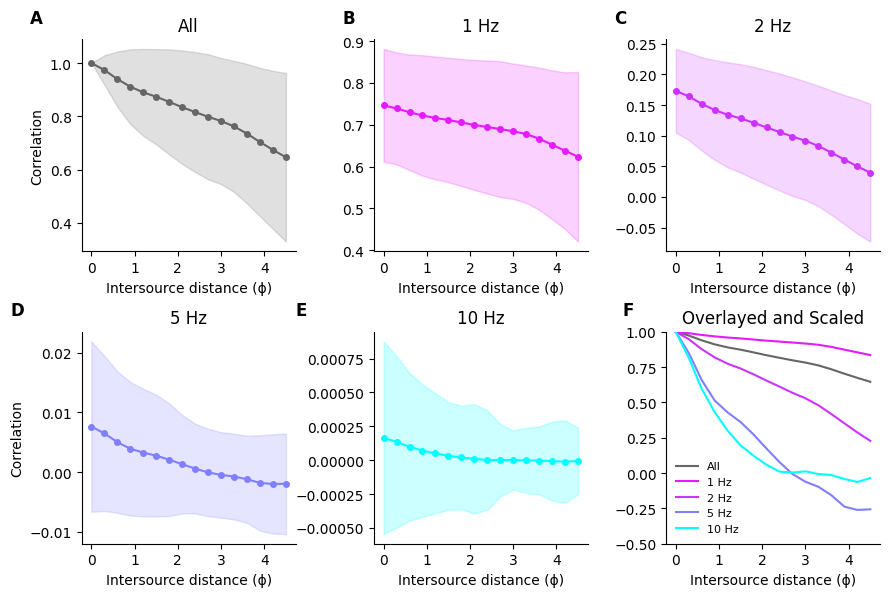

s=p
Mapped frequencies [ 1  2  5 10] Hz to indices [1, 2, 5, 10].


Wrote figs/kaiser16/1s/corr_components_s=p.pdf.


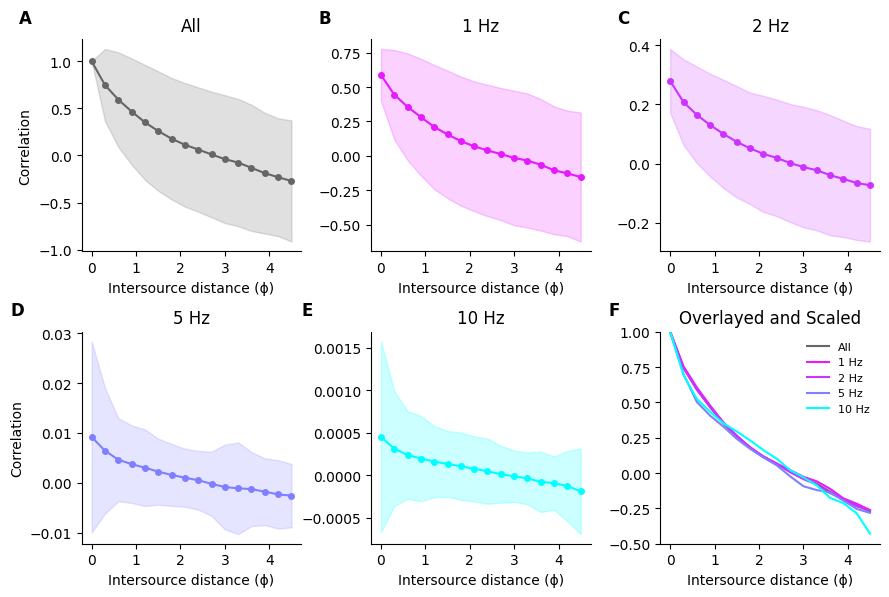

shw
Mapped frequencies [ 1  2  5 10] Hz to indices [1, 2, 5, 10].


Wrote figs/kaiser16/1s/corr_components_shw.pdf.


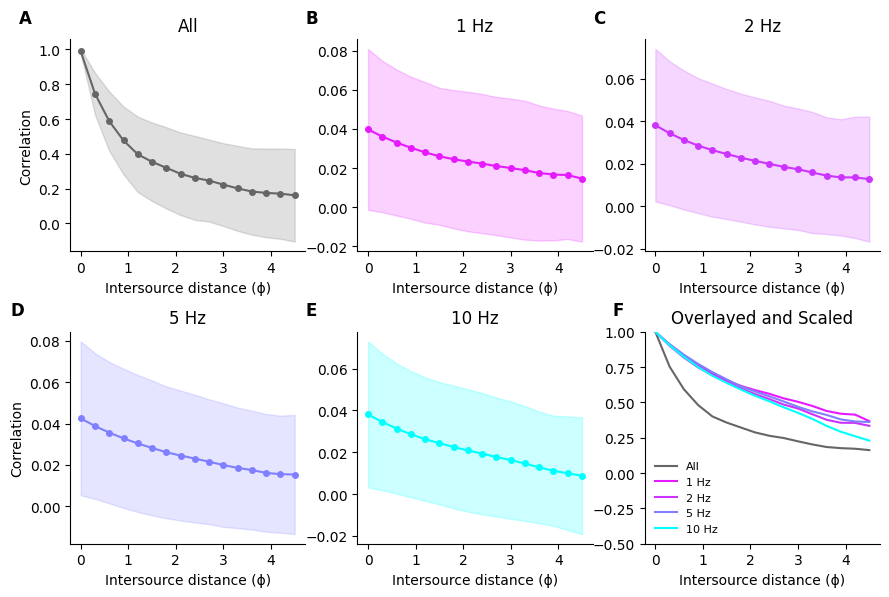

shp
Mapped frequencies [ 1  2  5 10] Hz to indices [1, 2, 5, 10].


Wrote figs/kaiser16/1s/corr_components_shp.pdf.


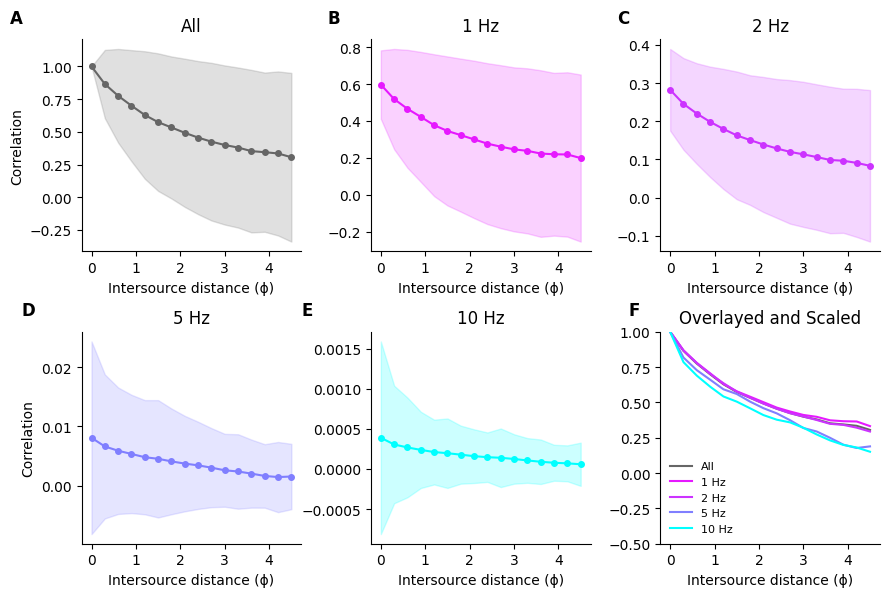

In [12]:
reload(fpf)
xlims_  = defaultdict(lambda: DEFAULT) #{"su_high":DEFAULT, "su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
xticks_ = defaultdict(lambda: DEFAULT) #{"su_high":DEFAULT, "su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
for k, F in data.items():
    which_freqs = [1,2,5,10] * UNITS.Hz
    labs = [f"{f}" for f in which_freqs]
    cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f.magnitude/10) for f in which_freqs])})    
    print(k)
    slices = {"All":slice(1,10000)}
    freq_inds = F.freqs2inds(which_freqs)
    print(f"Mapped frequencies {which_freqs} to indices {freq_inds}.")
    slices.update({l:slice(fi, fi+1) for l, fi in zip(labs, freq_inds)})
    ax = fpf.plot_correlations(F.rho[iprb], F.pitch.to("um").magnitude, slices=slices, cols=cols, n_rows = 2, plot_order = ["All"] + labs)
    [(axi.set_xlabel(f"Intersource distance ({fpf.pitch_sym})"),
      not isdefault(xlims_[k])  and axi.set_xlim(xlims_[k]),
      not isdefault(xticks_[k]) and axi.set_xticks(xticks_[k])) for axi in ax]    
    file_name = f"{fig_dir_wnd_shp_len}/corr_components_{k}.pdf"
    fpft.label_axes(ax, "ABCDEF", fontsize=12, fontweight="bold", dy=-0.01)
    ax[-1].set_ylim(-0.5,1)
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."))
    sys.stdout.flush(); plt.show()

# The Multivariate Gaussian Fits

16Ts
Mapped 5 Hz to index 5.


Wrote figs/kaiser16/1s/coef_vs_coef_16Ts_5Hz.pdf.


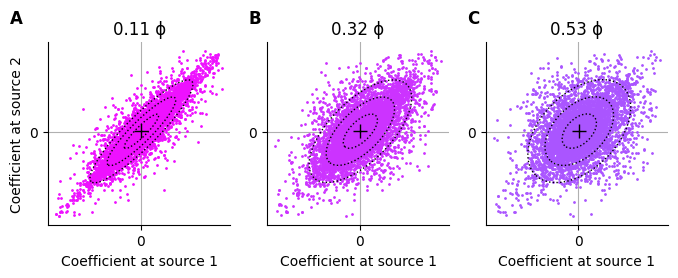

Mapped 10 Hz to index 10.


Wrote figs/kaiser16/1s/coef_vs_coef_16Ts_10Hz.pdf.


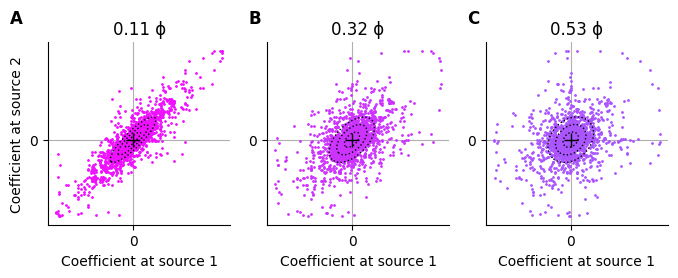

bw
Mapped 5 Hz to index 5.


Wrote figs/kaiser16/1s/coef_vs_coef_bw_5Hz.pdf.


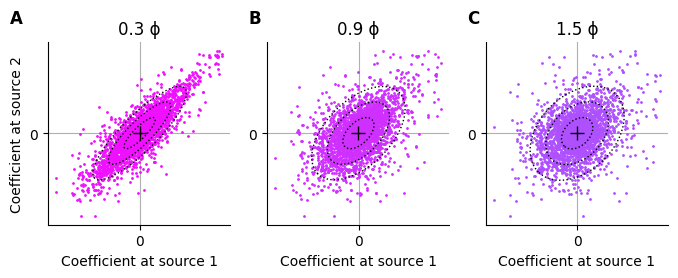

Mapped 10 Hz to index 10.


Wrote figs/kaiser16/1s/coef_vs_coef_bw_10Hz.pdf.


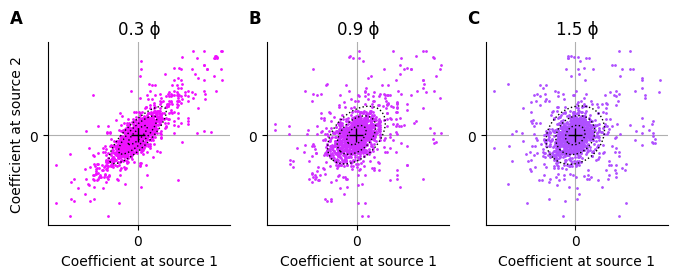

s=p
Mapped 5 Hz to index 5.


Wrote figs/kaiser16/1s/coef_vs_coef_s=p_5Hz.pdf.


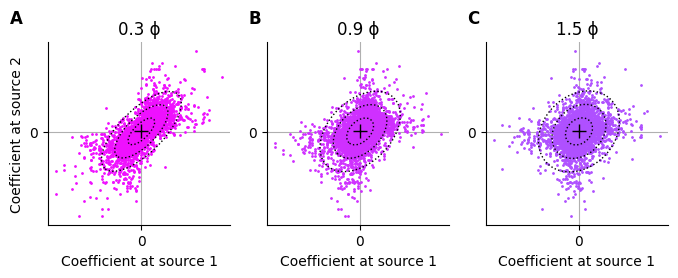

Mapped 10 Hz to index 10.


Wrote figs/kaiser16/1s/coef_vs_coef_s=p_10Hz.pdf.


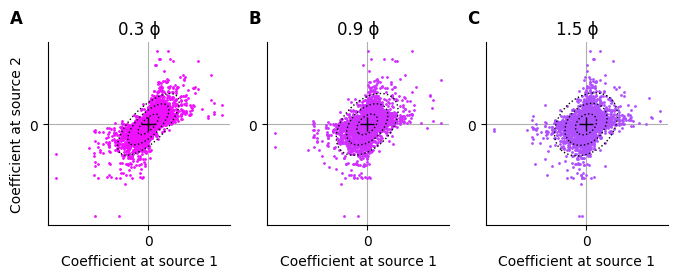

shp
Mapped 5 Hz to index 5.


Wrote figs/kaiser16/1s/coef_vs_coef_shp_5Hz.pdf.


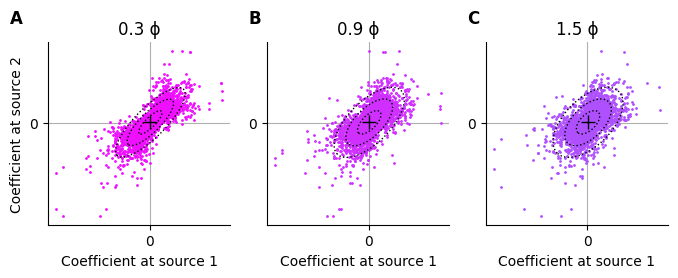

Mapped 10 Hz to index 10.


Wrote figs/kaiser16/1s/coef_vs_coef_shp_10Hz.pdf.


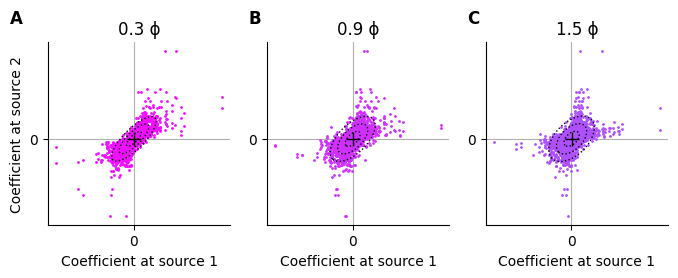

shw
Mapped 5 Hz to index 5.


Wrote figs/kaiser16/1s/coef_vs_coef_shw_5Hz.pdf.


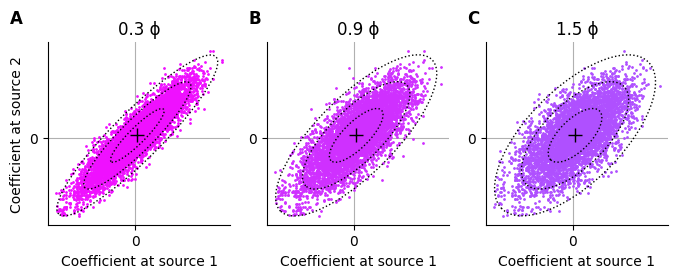

Mapped 10 Hz to index 10.


Wrote figs/kaiser16/1s/coef_vs_coef_shw_10Hz.pdf.


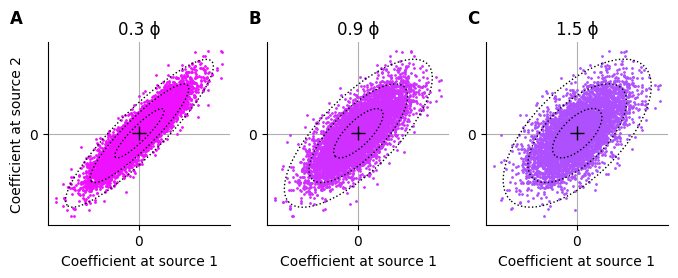

In [13]:
reload(fpf)
freqs_to_plot = [5 * UNITS.Hz, 10 * UNITS.Hz]
which_freqs = dict_update_from_field({"bw":freqs_to_plot,   "cr":freqs_to_plot},   su_ds + ["16Ts"], "bw"); 
which_idists= dict_update_from_field({"bw":[0,2,4],         "cr":[8,12,18]},       su_ds + ["16Ts"], "bw"); 
dcol_scales = dict_update_from_field({"bw":120000,          "cr":80000},           su_ds + ["16Ts"], "bw"); 
for name, F in sorted(data.items()):
    print(name)
    for which_freq in which_freqs[name]:
        ifreq = F.freqs2inds([which_freq])[0]
        print(f"Mapped {which_freq} to index {ifreq}.")
        ax = fpf.plot_coef1_vs_coef2([F.ss[iprb], F.cc[iprb]],
                                     ifreq,
                                     F.pairs_um,
                                     F.pitch_string,                                 
                                i_pos_dists_to_plot = which_idists[name],
                                dist_col_scale = dcol_scales[name]
        )
        fpft.label_axes(ax, "ABC", fontsize=12, fontweight="bold", dy=-0.01)            
        file_name = f"{fig_dir_wnd_shp_len}/coef_vs_coef_{name}_{which_freq.magnitude}Hz.pdf"
        SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
        sys.stdout.flush(); plt.show()

### Supplementary Information

Wrote figs/kaiser16/1s/coefs_and_traces_16Ts_5Hz.png.


<Figure size 800x300 with 0 Axes>

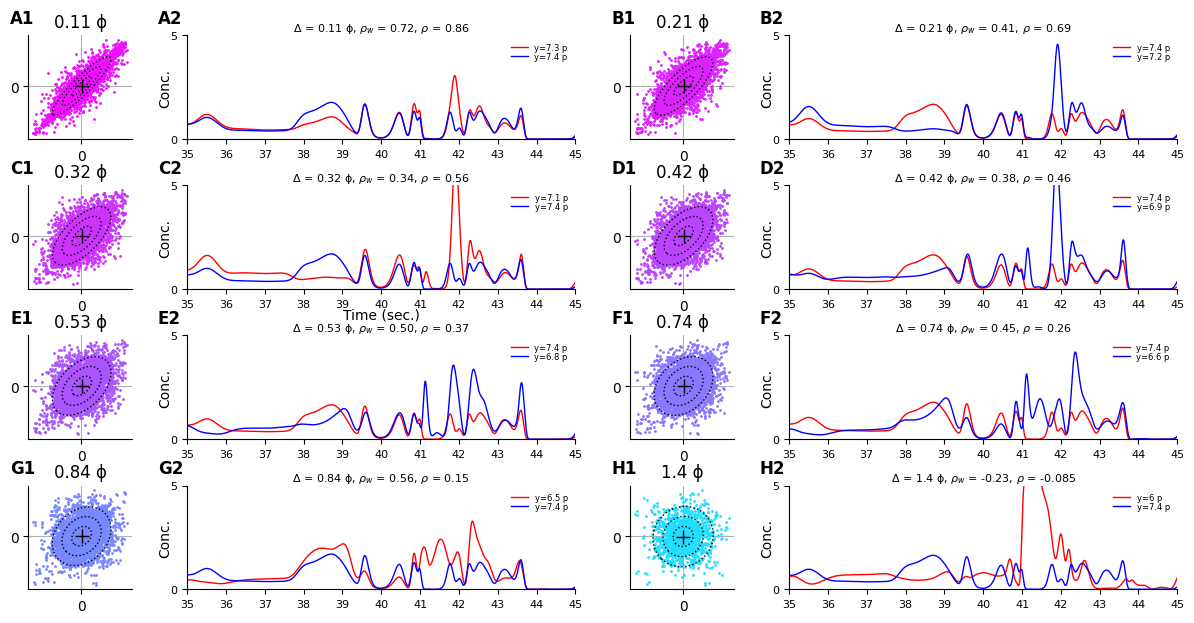

Wrote figs/kaiser16/1s/coefs_and_traces_bw_5Hz.png.


<Figure size 800x300 with 0 Axes>

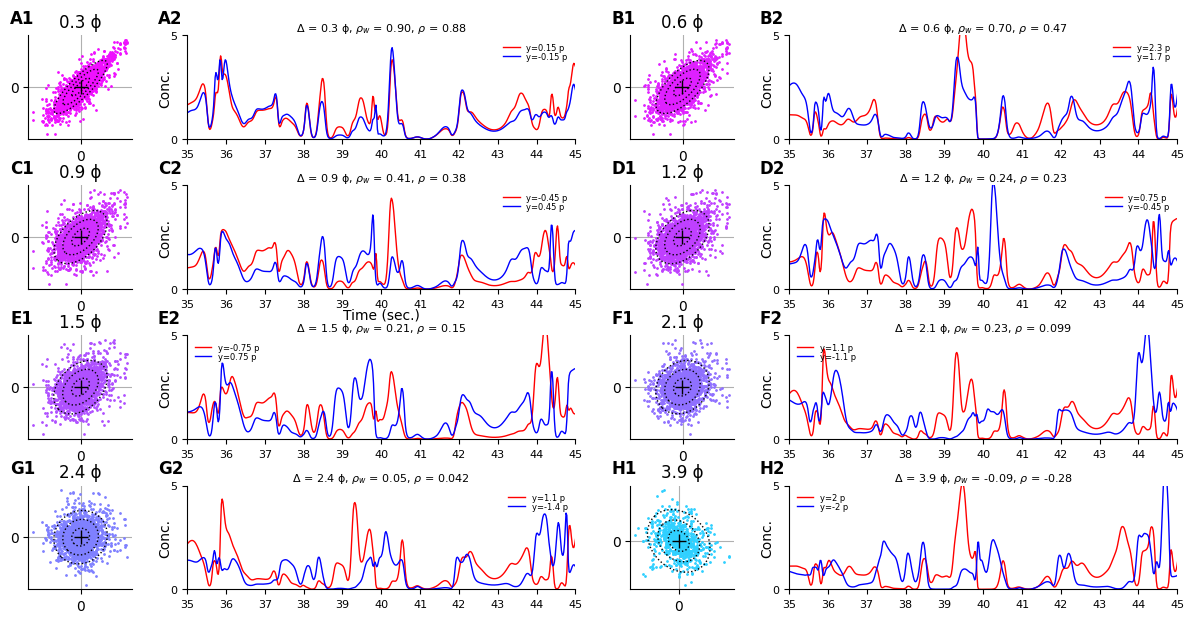

In [14]:
reload(fpf)
reload(fpft)
freq      = dict_update_from_field({"bw":5 * UNITS.hertz,          "cr":5 * UNITS.hertz},        su_ds + ["16Ts", "16T"], "bw"); 
idists    = dict_update_from_field({"bw":[0,1,2,3,4,6,7,12],       "cr":[0,4,8,12,16,20,21,22]}, su_ds + ["16Ts", "16T"], "bw"); 
t_lim     = dict_update_from_field({"bw":[35, 45]*UNITS.sec,       "cr":[39.5,40.5]*UNITS.sec,  "16T":[9.5,10.5]*UNITS.sec},  su_ds + ["16Ts"], "bw")
dt        = dict_update_from_field({"bw":1*UNITS.sec,              "cr":0.25*UNITS.sec},         su_ds + ["16Ts"], "bw", ["16T"], "cr");
for k, F in sorted(data.items()):
    if surrQ(k): continue
    figure(figsize=(12,6))
    coef_ax, trace_ax = fpf.plot_coef_vs_coef_and_traces(F, freq[k], idists[k],
                                                         which_probe = iprb, n_per_row = 2,
                                                         y_lim=[0,5] if k[:2]!="su" else [-3,3],
                                                         t_lim = t_lim[k],
                                                         dt = dt[k])
    for ax in coef_ax:
        ax.set_xlabel("")
        ax.set_ylabel("")
    [ax.legend(fontsize=6,labelspacing=0,frameon=False) for ax in trace_ax]
    tight_layout(pad=0)
    all_ax = bsum([[ax_c, ax_t] for ax_c, ax_t in zip(coef_ax, trace_ax)], [])
    n_ax   = len(all_ax)
    fpft.label_axes(all_ax,
                    [ch+nu for ch in "ABCDEFGH" for nu in "12"],
                    align_x = [list(range(i,n_ax,4)) for i in range(4)],
                    align_y = [list(range(i,i+4)) for i in range(0,n_ax,4)],
                    fontsize=12, fontweight="bold", dy=-0.01)
    file_name = f"{fig_dir_wnd_shp_len}/coefs_and_traces_{k}_{freq[k].to(UNITS.hertz).magnitude}Hz.png" # Use png as these figures have lots of points
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

#  Asymmetric Laplacian Fits

/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:314: RuntimeWarning: divide by zero encountered in log10
  INFO(f"{d=:3d} @ Freq # {which_ifreq:3d}: -np.log10(p) = {-np.log10(F.pvals[which_probe][d][0][which_ifreq]):1.3f}")
      fisher_plumes_figs 2023/07/11 11:09:10     INFO: d=8000 @ Freq #   1: -np.log10(p) = inf


      fisher_plumes_figs 2023/07/11 11:09:11     INFO: d=16000 @ Freq #   1: -np.log10(p) = inf


      fisher_plumes_figs 2023/07/11 11:09:11     INFO: d=24000 @ Freq #   1: -np.log10(p) = inf


16Ts
Setting extent to [-0.5, 15.5, 0.5, 20.5].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/kaiser16/1s/alap_fits_16Ts_1Hz.pdf.


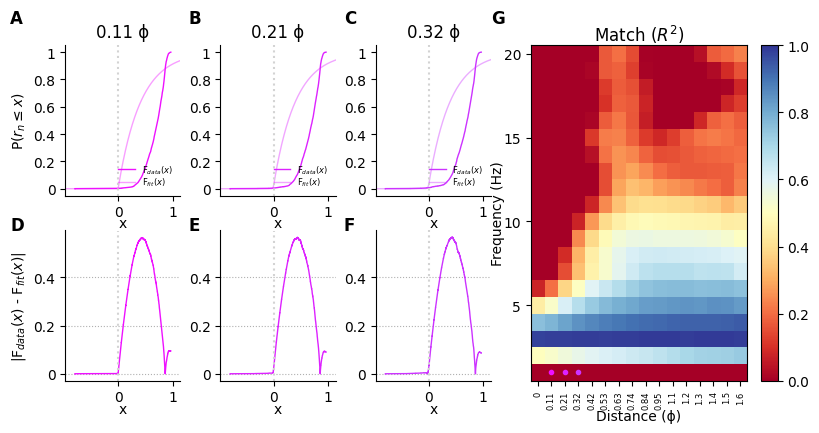

/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:314: RuntimeWarning: divide by zero encountered in log10
  INFO(f"{d=:3d} @ Freq # {which_ifreq:3d}: -np.log10(p) = {-np.log10(F.pvals[which_probe][d][0][which_ifreq]):1.3f}")
      fisher_plumes_figs 2023/07/11 11:09:12     INFO: d=8000 @ Freq #   5: -np.log10(p) = inf


      fisher_plumes_figs 2023/07/11 11:09:12     INFO: d=16000 @ Freq #   5: -np.log10(p) = inf


      fisher_plumes_figs 2023/07/11 11:09:12     INFO: d=24000 @ Freq #   5: -np.log10(p) = inf


Setting extent to [-0.5, 15.5, 0.5, 20.5].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/kaiser16/1s/alap_fits_16Ts_5Hz.pdf.


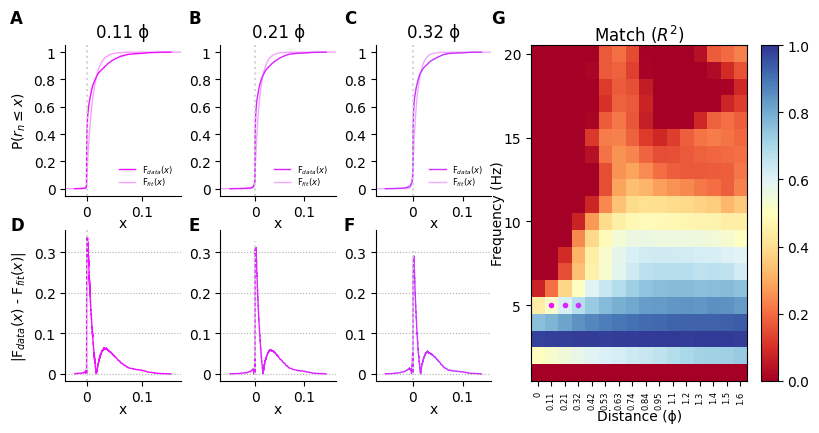

/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:314: RuntimeWarning: divide by zero encountered in log10
  INFO(f"{d=:3d} @ Freq # {which_ifreq:3d}: -np.log10(p) = {-np.log10(F.pvals[which_probe][d][0][which_ifreq]):1.3f}")
      fisher_plumes_figs 2023/07/11 11:09:13     INFO: d=8000 @ Freq #  10: -np.log10(p) = inf


      fisher_plumes_figs 2023/07/11 11:09:13     INFO: d=16000 @ Freq #  10: -np.log10(p) = inf


      fisher_plumes_figs 2023/07/11 11:09:13     INFO: d=24000 @ Freq #  10: -np.log10(p) = inf


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Setting extent to [-0.5, 15.5, 0.5, 20.5].


Wrote figs/kaiser16/1s/alap_fits_16Ts_10Hz.pdf.


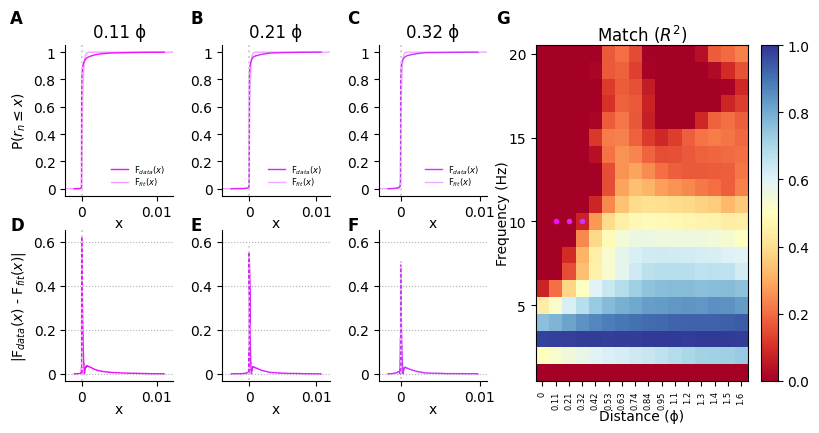

/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:314: RuntimeWarning: divide by zero encountered in log10
  INFO(f"{d=:3d} @ Freq # {which_ifreq:3d}: -np.log10(p) = {-np.log10(F.pvals[which_probe][d][0][which_ifreq]):1.3f}")
      fisher_plumes_figs 2023/07/11 11:09:15     INFO: d=7500 @ Freq #   1: -np.log10(p) = inf


      fisher_plumes_figs 2023/07/11 11:09:15     INFO: d=15000 @ Freq #   1: -np.log10(p) = inf


      fisher_plumes_figs 2023/07/11 11:09:15     INFO: d=22500 @ Freq #   1: -np.log10(p) = inf


bw
Setting extent to [-0.5, 15.5, 0.5, 20.5].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/kaiser16/1s/alap_fits_bw_1Hz.pdf.


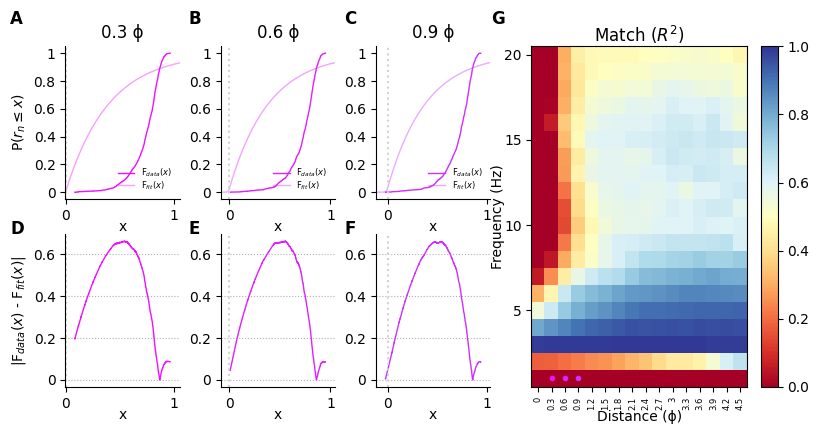

      fisher_plumes_figs 2023/07/11 11:09:16     INFO: d=7500 @ Freq #   5: -np.log10(p) = 253.878


      fisher_plumes_figs 2023/07/11 11:09:16     INFO: d=15000 @ Freq #   5: -np.log10(p) = 181.394


      fisher_plumes_figs 2023/07/11 11:09:16     INFO: d=22500 @ Freq #   5: -np.log10(p) = 145.502


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Setting extent to [-0.5, 15.5, 0.5, 20.5].


Wrote figs/kaiser16/1s/alap_fits_bw_5Hz.pdf.


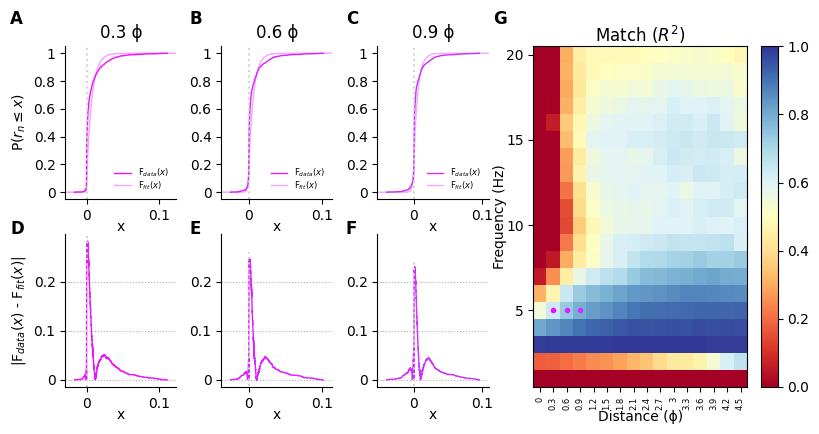

/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:314: RuntimeWarning: divide by zero encountered in log10
  INFO(f"{d=:3d} @ Freq # {which_ifreq:3d}: -np.log10(p) = {-np.log10(F.pvals[which_probe][d][0][which_ifreq]):1.3f}")
      fisher_plumes_figs 2023/07/11 11:09:18     INFO: d=7500 @ Freq #  10: -np.log10(p) = inf


      fisher_plumes_figs 2023/07/11 11:09:18     INFO: d=15000 @ Freq #  10: -np.log10(p) = inf


      fisher_plumes_figs 2023/07/11 11:09:18     INFO: d=22500 @ Freq #  10: -np.log10(p) = inf


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Setting extent to [-0.5, 15.5, 0.5, 20.5].


Wrote figs/kaiser16/1s/alap_fits_bw_10Hz.pdf.


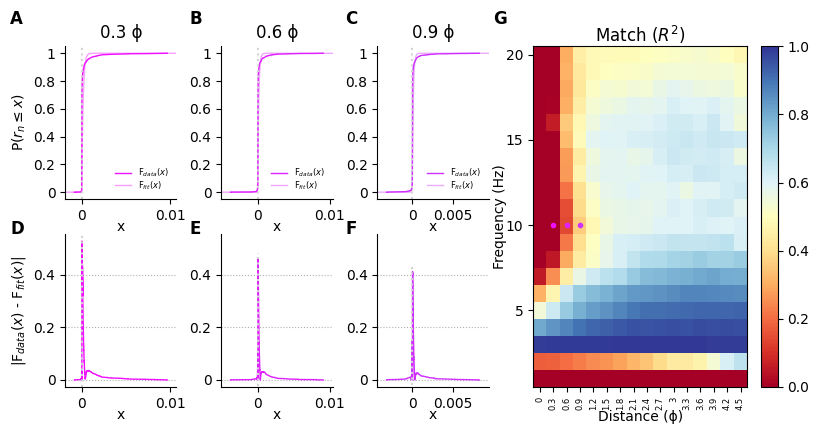

In [15]:
reload(fpft)
reload(fpf)
idist     = dict_update_from_field({"bw":[1,2,3],          "cr":[1,13,15]},         su_ds + ["16Ts"], "bw", ["16T"],"cr")
freq_max  = dict_update_from_field({"bw":21 * UNITS.hertz, "cr":101 * UNITS.hertz}, su_ds + ["16Ts"], "bw", ["16T"],"cr")
vmin      = dict_update_from_field({"bw":[0,0.0],          "cr":[0,0.5]},           su_ds + ["16Ts"], "bw", ["16T"],"cr")
vmax      = dict_update_from_field({"bw":[50,1],           "cr":[10,1]},            su_ds + ["16Ts"], "bw", ["16T"],"cr")
plot_pvals= False
for name, F in sorted(data.items()):
    if surrQ(name): continue
    print(name)
    d = np.array(list(F.rho[iprb].keys()))
    d = np.sort(d[d>=0])
    for f in [1, 5, 10] * UNITS.hertz:
        which_freq = defaultdict(lambda: f)
        ax_cdf, ax_dcdf, ax_hm = fpf.plot_alaplace_fits(F, d[idist[name]],
                                                        which_probe = iprb,
                               ifreq_lim = [1, F.freqs2inds([freq_max[name]])[0]],
                               which_ifreq = F.freqs2inds([which_freq[name]])[0],
                                                        figsize=(8,4),
                                                        vmax=vmax[name],
                                                        vmin=vmin[name],
                                                        plot_dvals=True,
                                                        plot_pvals=plot_pvals)
        tight_layout(pad=0)
        fpft.label_axes(ax_cdf + ax_dcdf + ax_hm, "ABCDEFGHIJK",
                        align_y = [[0,1,2,6],[3,4,5,7]] if plot_pvals else [[0,1,2],[3,4,5]],
                        align_x = [[0,3],[1,4],[2,5]],
                        fontsize=12, fontweight="bold", dy=0)
        file_name = f"{fig_dir_wnd_shp_len}/alap_fits_{name}_{which_freq[name].to(UNITS.hertz).magnitude}Hz.pdf"
        SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
        sys.stdout.flush(); plt.show()

# Plot the figure showing λ(s)

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)
      fisher_plumes_figs 2023/07/11 11:09:19     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 3, 7, 10], log_scale=True.


Wrote figs/kaiser16/1s/fit_k=True/la_vs_s_fits_16Ts.pdf.


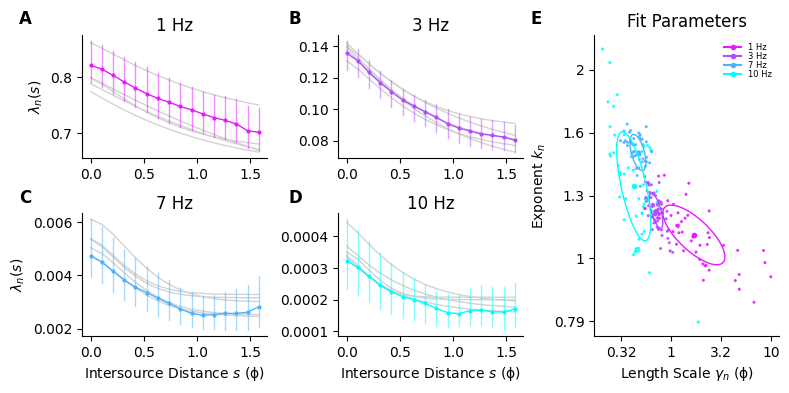

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)
      fisher_plumes_figs 2023/07/11 11:09:21     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 3, 7, 10], log_scale=True.


Wrote figs/kaiser16/1s/fit_k=True/la_vs_s_fits_bw.pdf.


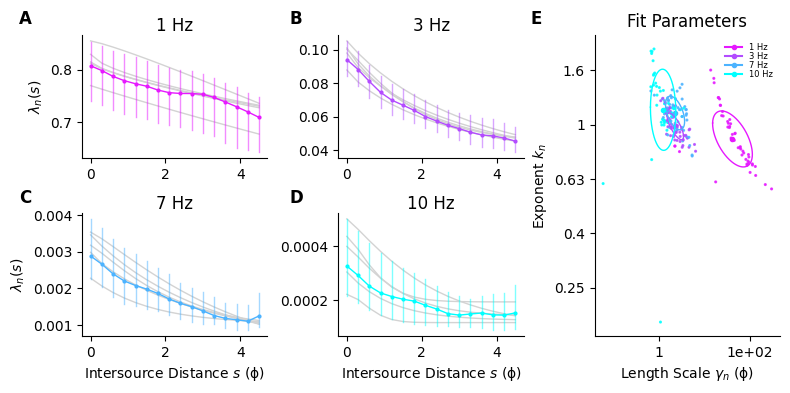

In [16]:
reload(fpft)
reload(fpf)
freqs  = dict_update({fld:[1,3,7,10] * UNITS.hertz for fld in ["bw", "cr", "su", "16T", "16Ts"]}, ["su_high_white", "su_high_pink", "su_high2_pink", "su_white"], [[1,3,17,20] * UNITS.hertz]*4)
xl     = dict_update_from_field({"bw":(-10,200),                 "cr": (-2, 50)},                    su_ds + ["16Ts"], "bw", ["16T"], "cr")
xt     = dict_update_from_field({"bw":arange(0,201,50),          "cr": arange(0,101,25)},            su_ds + ["16Ts"], "bw", ["16T"], "cr")
xtp    = dict_update_from_field({"bw":np.array([60,90,135]),     "cr": np.array([40,60, 90, 135])},  su_ds + ["16Ts"], "bw", ["16T"], "cr")
ytp    = dict_update_from_field({"bw":np.array([0.8,1,1.2,1.5]), "cr": np.array([0.8,1,1.2,1.5,2])}, su_ds + ["16Ts"], "bw", ["16T"], "cr")

#print(f"{wnd_key=:}")
#data_wnd = {k:v[wnd_key] for k,v in proc.items() if wnd_key in v and k != "su_high_pink"}
for k, F in sorted(data.items()):
    if surrQ(k): continue
    ax = fpf.plot_la_gen_fits_vs_distance(F, 
                                          figsize=(8,4), legloc = 'right',
                                          log_scale = True,
                                          scatter_size=1.5,
                                          which_ifreqs = F.freqs2inds(freqs[k]))
    [((i>1) and axi.set_xlabel(f"Intersource Distance $s$ ({fpf.pitch_sym})")) for i, axi in enumerate(ax[:4])]
    tight_layout(h_pad=1,w_pad=0.5)
    fpft.label_axes(ax, "ABCDEFGHIJK",
                    align_y = [[0,1,4],[2,3]],
                    align_x = [[0,2],[1,3]],
                    fontsize=12, fontweight="bold", dy=-0.02)                        
    file_name = f"{fig_dir_full}/la_vs_s_fits_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Plot the Fisher Information

      fisher_plumes_figs 2023/07/11 11:09:22     INFO: dd[0]=100, dd[-1]=125000 (0.00131579, 1.64474 ϕ)


      fisher_plumes_figs 2023/07/11 11:09:22     INFO: Plotting which_ifreqs=[1, 2, 5, 10, 20].


16Ts


Wrote figs/kaiser16/1s/fit_k=True/fisher_info_16Ts.pdf.


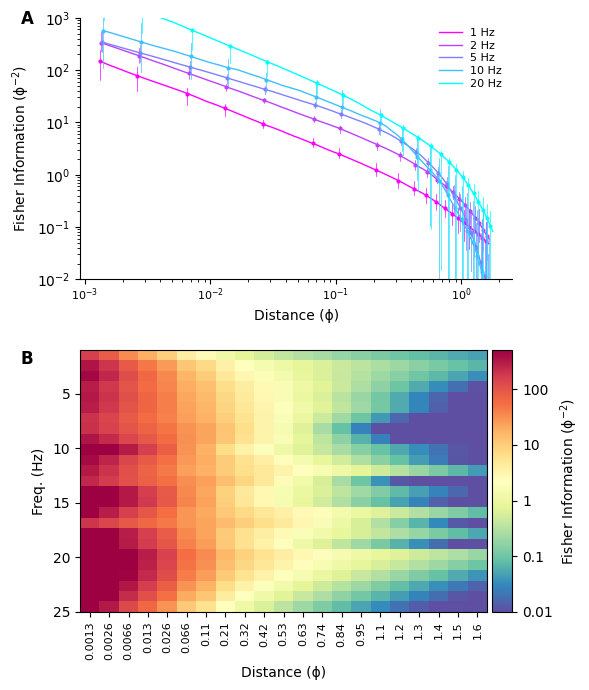

      fisher_plumes_figs 2023/07/11 11:09:24     INFO: dd[0]=100, dd[-1]=125000 (0.004, 5 ϕ)


      fisher_plumes_figs 2023/07/11 11:09:24     INFO: Plotting which_ifreqs=[1, 2, 5, 10, 20].


bw


Wrote figs/kaiser16/1s/fit_k=True/fisher_info_bw.pdf.


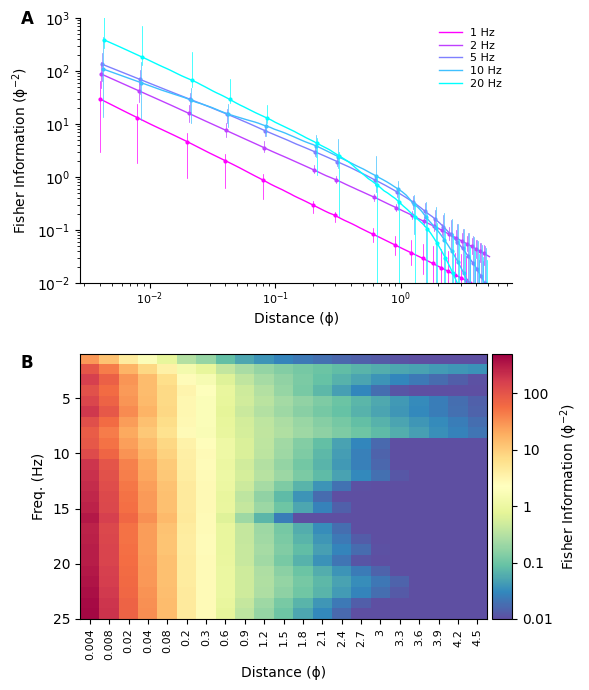

      fisher_plumes_figs 2023/07/11 11:09:26     INFO: dd[0]=100, dd[-1]=125000 (0.004, 5 ϕ)


      fisher_plumes_figs 2023/07/11 11:09:26     INFO: Plotting which_ifreqs=[1, 2, 5, 10, 20].


s=p


Wrote figs/kaiser16/1s/fit_k=True/fisher_info_s=p.pdf.


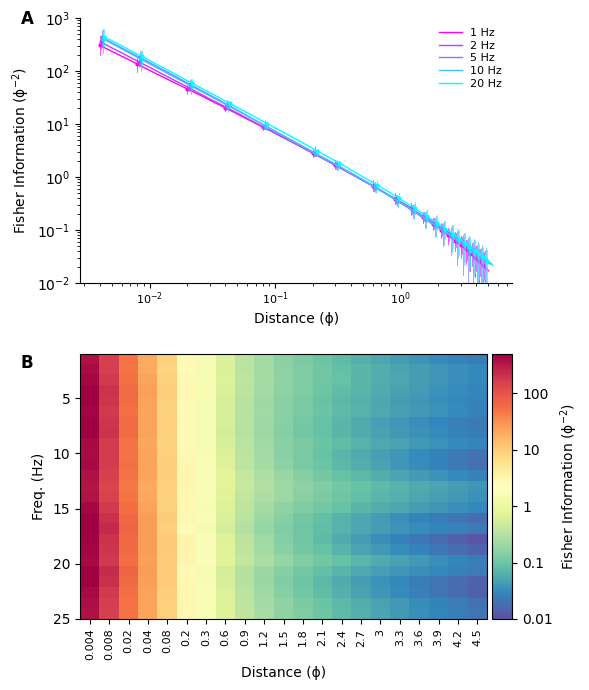

      fisher_plumes_figs 2023/07/11 11:09:27     INFO: dd[0]=100, dd[-1]=125000 (0.004, 5 ϕ)


      fisher_plumes_figs 2023/07/11 11:09:27     INFO: Plotting which_ifreqs=[1, 2, 5, 10, 20].


shp


Wrote figs/kaiser16/1s/fit_k=True/fisher_info_shp.pdf.


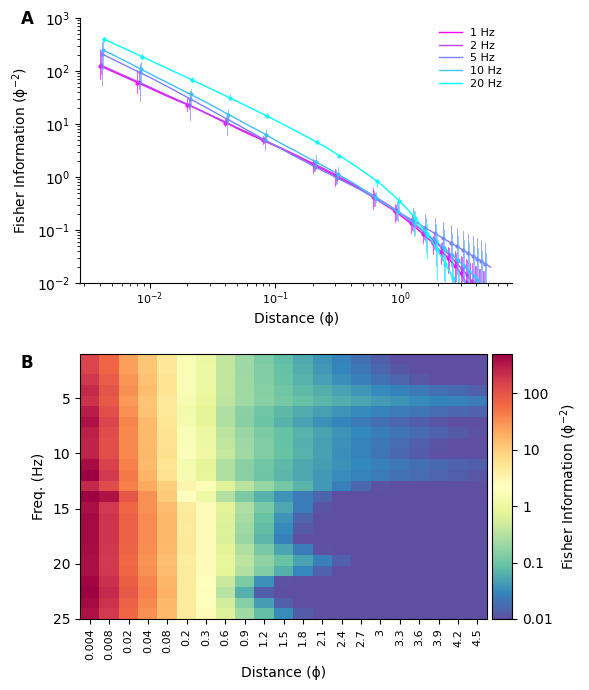

      fisher_plumes_figs 2023/07/11 11:09:29     INFO: dd[0]=100, dd[-1]=125000 (0.004, 5 ϕ)


      fisher_plumes_figs 2023/07/11 11:09:29     INFO: Plotting which_ifreqs=[1, 2, 5, 10, 20].


shw


Wrote figs/kaiser16/1s/fit_k=True/fisher_info_shw.pdf.


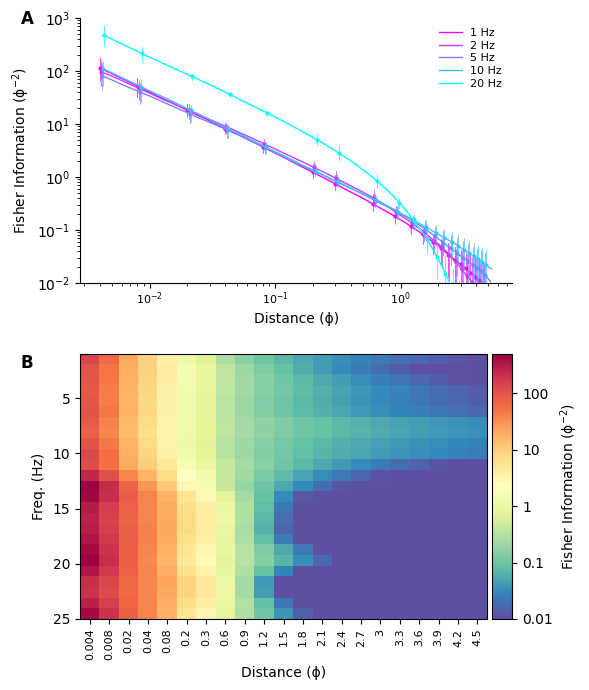

In [17]:
reload(fpt)
reload(fpft)
reload(fpf)
freqs     = dict_update_from_field({"cr":[5,10,20,50,100] * UNITS.hertz, "bw":[1,2, 5, 10, 20] * UNITS.hertz}, su_ds + ["16Ts"], "bw", ["16T"], "cr")
freq_max  = dict_update_from_field({"bw":25 * UNITS.hertz, "cr":100 * UNITS.hertz}, su_ds + ["16Ts"], "bw", ["16T"], "cr")
colscale  = dict_update_from_field({"bw":10,               "cr":40},                su_ds + ["16Ts"], "bw", ["16T"], "cr")
d_vals_um = dict_update_from_field({"bw":[1,5,50],         "cr":[0.1,10,70]},       su_ds + ["16Ts"], "bw", ["16T"], "cr")
d_lim_um  = dict_update_from_field({"bw":[100, 125000 ],   "cr":[100, 125000]},     su_ds + ["16Ts"], "bw", ["16T"], "cr")
bf_ytick  = dict_update_from_field({"bw":[0,5,10],         "cr":[0,50,100]},        su_ds + ["16Ts"], "bw", ["16T"], "cr")
bf_yl     = dict_update_from_field({"bw":[0,15],           "cr":[-5,100]},          su_ds + ["16Ts"], "bw", ["16T"], "cr")
plot_param_fits = False
for k, F in sorted(data.items()):
    print(k)
    figure(figsize=(6,7))
    ax_fisher, ax_best_freq, ax_d = fpf.plot_fisher_information(F,
                                                                which_probe = iprb,
                                                                d_lim_um   = d_lim_um[k],
                                                                d_vals_um  = np.array(d_vals_um[k])*1000,
                                                                d_space_fun  = lambda d0,d1,n:np.logspace(log10(d0),log10(d1),n),
                                                                which_ifreqs = F.freqs2inds(freqs[k]),
                                                                x_stagger = lambda x, i: x*(1.02**i),
                                                                plot_fun = plt.loglog,
                                                                log_scale = True,
                                                                plot_param_fits = plot_param_fits,
                                                                freq_max  = freq_max[k],
                                                                colfun    = lambda f: cm.cool_r(f/colscale[k]),
                                                                info_heatmap = True,
                                                                heatmap_range =[-2, log10(500)],
                                                                heatmap_cm    =cm.Spectral_r,
                                                                #bf_ytick  = bf_ytick[k],
    )
    ax_fisher.set_ylim(1e-2,1e3)
    tight_layout(h_pad=2,w_pad=0)
    fpft.label_axes([ax_fisher, ax_best_freq] + ax_d , "ABCDEFGHIJK",
                    #align_y = [[2,3,4]],
                    align_x = [[0,1,2] if plot_param_fits else [0,1]],
                    fontsize=12, fontweight="bold", dy=-0.02)
    #ax_best_freq.set_ylim(bf_yl[k])
    file_name = f"{fig_dir_full}/fisher_info_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()
    

# Plot Fisher information heatmaps together

In [18]:
order = ["bw", "s=p", "shw", "shp"]
which_wnd = (1 * UNITS.s, 'boxcar')
data_wnd = {o:FisherPlumes(proc.load_data(init_filter=to_use[o], compute_filter = {"window_length":which_wnd[0], "window_shape":which_wnd[1], "fit_k":fit_k})[0], load_sims=False) for o in order}

                    proc 2023/07/11 11:09:31     INFO: Loading init_filter={'sim_name': 'boulder16'} compute_filter={'window_length': <Quantity(1, 'second')>, 'window_shape': 'boxcar', 'fit_k': True} from proc/bw.1/d82d7457825214eb.p


                    proc 2023/07/11 11:09:34     INFO: Returning 1 results.


           fisher_plumes 2023/07/11 11:09:34     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/11 11:09:34     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/11 11:09:34     INFO: Copied 35 data fields from supplied dictionary.


                    proc 2023/07/11 11:09:34     INFO: Loading init_filter={'sim_name': 'surr_all_equal'} compute_filter={'window_length': <Quantity(1, 'second')>, 'window_shape': 'boxcar', 'fit_k': True} from proc/su.1/2d4749e757f4ae59.p


                    proc 2023/07/11 11:09:35     INFO: Returning 1 results.


           fisher_plumes 2023/07/11 11:09:35     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/11 11:09:35     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/11 11:09:35     INFO: Copied 35 data fields from supplied dictionary.


                    proc 2023/07/11 11:09:35     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 0} compute_filter={'window_length': <Quantity(1, 'second')>, 'window_shape': 'boxcar', 'fit_k': True} from proc/suw.1/0bdbc418ca8e3f5e.p


                    proc 2023/07/11 11:09:35     INFO: Returning 1 results.


           fisher_plumes 2023/07/11 11:09:35     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/11 11:09:35     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/11 11:09:35     INFO: Copied 35 data fields from supplied dictionary.


                    proc 2023/07/11 11:09:35     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 4} compute_filter={'window_length': <Quantity(1, 'second')>, 'window_shape': 'boxcar', 'fit_k': True} from proc/sup.1/d5a72a043f07234f.p


                    proc 2023/07/11 11:09:36     INFO: Returning 1 results.


           fisher_plumes 2023/07/11 11:09:36     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/11 11:09:36     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/11 11:09:36     INFO: Copied 35 data fields from supplied dictionary.


Wrote figs/fit_k=True/fisher_info_heatmaps.pdf.


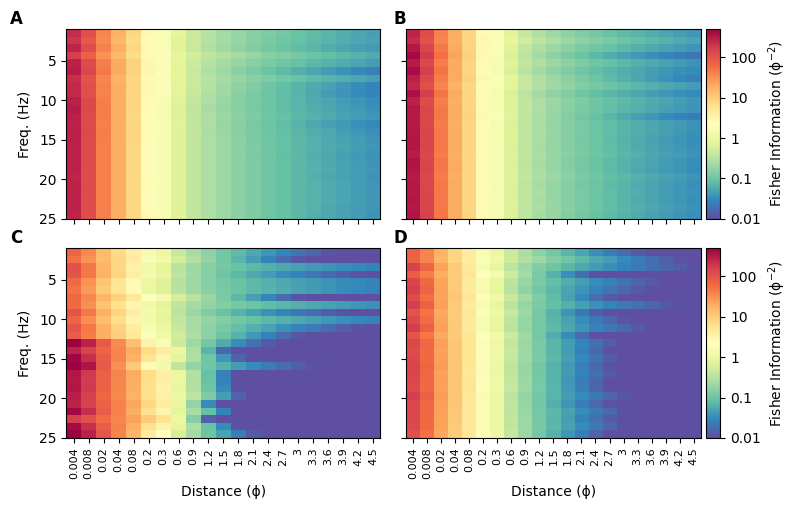

In [19]:
figure(figsize=(8,5))
gs = GridSpec(2,2)
axes, cbs = [], []
for o, gsi in zip(order, gs):
    axes.append(subplot(gsi))
    axes[-1], cbi = fpf.plot_fisher_information_heatmap(data_wnd[o], 0, ax = axes[-1], freq_max = freq_max[o],
                                                        heatmap_range =[-2, log10(500)],
                                                        heatmap_cm    =cm.Spectral_r,
                                                        do_colorbar   = gsi.is_last_col(),
    )
    if gsi.is_first_row():
        axes[-1].tick_params(labelbottom=False)
        axes[-1].set_xlabel("")

    if not gsi.is_first_col():
        axes[-1].tick_params(labelleft = False)
        axes[-1].set_ylabel("")
tight_layout(w_pad = 1.5, h_pad=1.5)
fpft.label_axes(axes, "ABCD",
                align_y = [[0,1],[2,3]],
                align_x = [[0,2],[1,3]],
                fontsize=12, fontweight="bold", dy=0.01, dx = -0.01)
file_name = f"{fig_dir_fitk}/fisher_info_heatmaps.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight', pad_inches=0), flush(f"Wrote {file_name}."));
sys.stdout.flush(); plt.show()
        

# Main figure showing effect of windowing

In [20]:
row_vals = ["s=p", "shp", "bw"]
col_vals = [(10 * UNITS.s, 'boxcar'), (1 * UNITS.s, 'hann'), (5 * UNITS.s, 'hann')]
data_grid= {(r,c):FisherPlumes(proc.load_data(init_filter=to_use[r], compute_filter = {"window_length":c[0], "window_shape":c[1], "fit_k":fit_k})[0], load_sims=False) for r in row_vals for c in col_vals}

                    proc 2023/07/11 11:09:38     INFO: Loading init_filter={'sim_name': 'surr_all_equal'} compute_filter={'window_length': <Quantity(10, 'second')>, 'window_shape': 'boxcar', 'fit_k': True} from proc/su.1/e58868247b3c6338.p


                    proc 2023/07/11 11:09:38     INFO: Returning 1 results.


           fisher_plumes 2023/07/11 11:09:38     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/11 11:09:38     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/11 11:09:38     INFO: Copied 35 data fields from supplied dictionary.


                    proc 2023/07/11 11:09:38     INFO: Loading init_filter={'sim_name': 'surr_all_equal'} compute_filter={'window_length': <Quantity(1, 'second')>, 'window_shape': 'hann', 'fit_k': True} from proc/su.1/41e194271bf77f2f.p


                    proc 2023/07/11 11:09:39     INFO: Returning 1 results.


           fisher_plumes 2023/07/11 11:09:39     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/11 11:09:39     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/11 11:09:39     INFO: Copied 35 data fields from supplied dictionary.


                    proc 2023/07/11 11:09:39     INFO: Loading init_filter={'sim_name': 'surr_all_equal'} compute_filter={'window_length': <Quantity(5, 'second')>, 'window_shape': 'hann', 'fit_k': True} from proc/su.1/d0364e19f217cda8.p


                    proc 2023/07/11 11:09:39     INFO: Returning 1 results.


           fisher_plumes 2023/07/11 11:09:39     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/11 11:09:39     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/11 11:09:40     INFO: Copied 35 data fields from supplied dictionary.


                    proc 2023/07/11 11:09:40     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 4} compute_filter={'window_length': <Quantity(10, 'second')>, 'window_shape': 'boxcar', 'fit_k': True} from proc/sup.1/baedabaaa47e54f4.p


                    proc 2023/07/11 11:09:40     INFO: Returning 1 results.


           fisher_plumes 2023/07/11 11:09:40     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/11 11:09:40     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/11 11:09:40     INFO: Copied 35 data fields from supplied dictionary.


                    proc 2023/07/11 11:09:40     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 4} compute_filter={'window_length': <Quantity(1, 'second')>, 'window_shape': 'hann', 'fit_k': True} from proc/sup.1/b63ba5e431b6bf4a.p


                    proc 2023/07/11 11:09:41     INFO: Returning 1 results.


           fisher_plumes 2023/07/11 11:09:41     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/11 11:09:41     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/11 11:09:41     INFO: Copied 35 data fields from supplied dictionary.


                    proc 2023/07/11 11:09:41     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 4} compute_filter={'window_length': <Quantity(5, 'second')>, 'window_shape': 'hann', 'fit_k': True} from proc/sup.1/ead8455231077f9b.p


                    proc 2023/07/11 11:09:42     INFO: Returning 1 results.


           fisher_plumes 2023/07/11 11:09:42     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/11 11:09:42     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/11 11:09:42     INFO: Copied 35 data fields from supplied dictionary.


                    proc 2023/07/11 11:09:42     INFO: Loading init_filter={'sim_name': 'boulder16'} compute_filter={'window_length': <Quantity(10, 'second')>, 'window_shape': 'boxcar', 'fit_k': True} from proc/bw.1/d5767326c46defbf.p


                    proc 2023/07/11 11:09:42     INFO: Returning 1 results.


           fisher_plumes 2023/07/11 11:09:42     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/11 11:09:42     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/11 11:09:43     INFO: Copied 35 data fields from supplied dictionary.


                    proc 2023/07/11 11:09:43     INFO: Loading init_filter={'sim_name': 'boulder16'} compute_filter={'window_length': <Quantity(1, 'second')>, 'window_shape': 'hann', 'fit_k': True} from proc/bw.1/c5fa2e25dca5495f.p


                    proc 2023/07/11 11:09:43     INFO: Returning 1 results.


           fisher_plumes 2023/07/11 11:09:43     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/11 11:09:43     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/11 11:09:44     INFO: Copied 35 data fields from supplied dictionary.


                    proc 2023/07/11 11:09:44     INFO: Loading init_filter={'sim_name': 'boulder16'} compute_filter={'window_length': <Quantity(5, 'second')>, 'window_shape': 'hann', 'fit_k': True} from proc/bw.1/7436e95ac2f306ad.p


                    proc 2023/07/11 11:09:45     INFO: Returning 1 results.


           fisher_plumes 2023/07/11 11:09:45     INFO: Initializing from dictionary.


           fisher_plumes 2023/07/11 11:09:45     INFO: Attempting to copy data fields.


           fisher_plumes 2023/07/11 11:09:45     INFO: Copied 35 data fields from supplied dictionary.


/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:731: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(I[ind_use]),


Wrote figs/fit_k=True/effect_of_windowing.pdf.


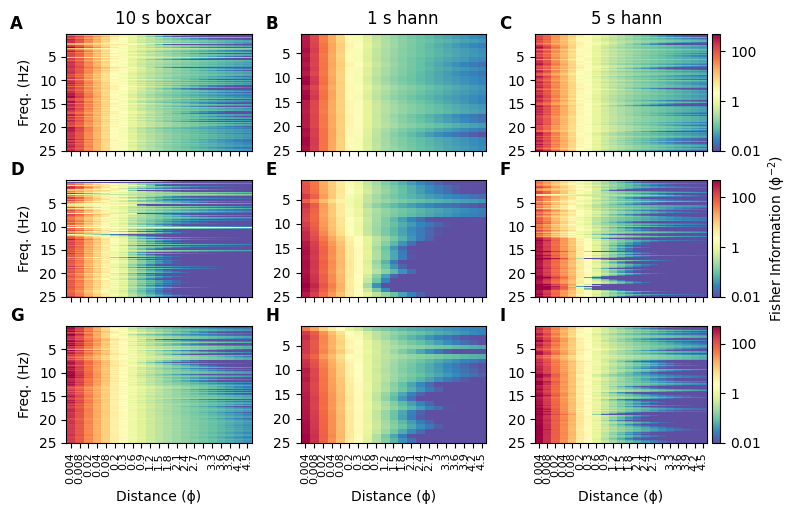

In [21]:
reload(fpf)
fig = figure(figsize=(8,5))
heatmap_range = defaultdict(lambda: [-2, log10(500)], {"bw":[-2,log10(500)], "su_high2_pink":[-2,log10(500)]})
gs       = GridSpec(len(row_vals), len(col_vals))
ax       = []
for i, ds in enumerate(row_vals):
    for j, ck in enumerate(col_vals):
        ax.append(subplot(gs[i,j]))
        p = data_grid[ds,ck]
        _, cb = fpf.plot_fisher_information_heatmap(
            p, 0, ax = ax[-1], heatmap_range = heatmap_range[ds],
            do_colorbar = gs[i,j].is_last_col(),
        )
        # Write text above each column
        
        i == 0 and fig.text({0:0.2,1:0.5,2:0.78}[j],1.0,f"{ck[0]} {utils.remove_non_alphanum(ck[1])}",va="center", ha="center", fontsize=12)
        if gs[i,j].is_last_col() and i!=1: cb.ax.set_ylabel("")
        if not gs[i,j].is_first_col(): ax[-1].set_ylabel("")
        if not gs[i,j].is_last_row():  [ax[-1].set_xlabel(""),ax[-1].set_xticklabels([])]
tight_layout(w_pad = 1.5, h_pad=1.5)
fpft.label_axes(ax, "ABCDEFGHI",
                align_y = [[0,1,2],[3,4,5],[6,7,8]],
                align_x = [[0,3,6],[1,4,7],[2,5,8]],
                fontsize=12, fontweight="bold", dy=0.01, dx = -0.01)
file_name = f"{fig_dir_fitk}/effect_of_windowing.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight', pad_inches=0), flush(f"Wrote {file_name}."));
sys.stdout.flush(); plt.show()
        


# Length constants vs frequency

Wrote figs/kaiser16/1s/fit_k=True/length_vs_freq_bw.pdf.


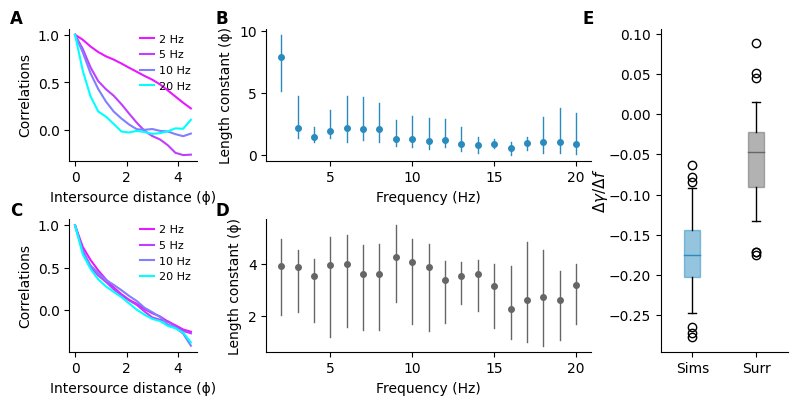

Wrote figs/kaiser16/1s/fit_k=True/length_vs_freq_16Ts.pdf.


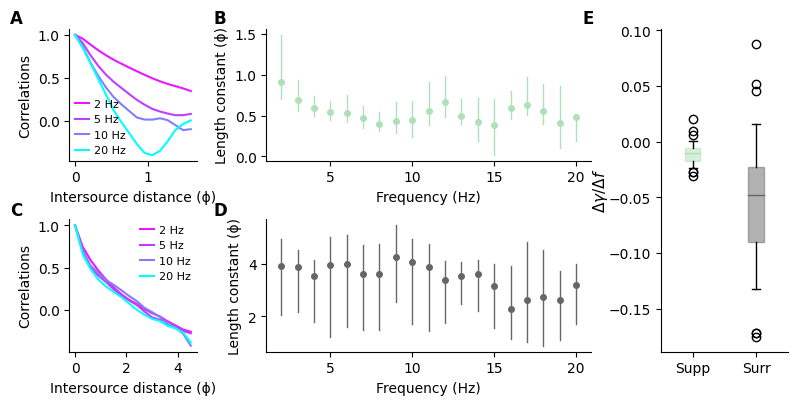

In [22]:
reload(fpf)
for ds in ["bw", "16Ts"]:
    which_ds = [ds,"s=p"]
    ax, ax_γ = fpf.plot_length_constants_vs_frequency(data, which_ds, iprb)
    fpft.label_axes(ax + [ax_γ], "ABCDE",
                    fontsize=12, fontweight="bold",
                    dx = -0.01, dy=0.01,
                    align_x = [[0,2],[1,3]],
                    align_y = [[0,1,4]])
    
    file_name = f"{fig_dir_full}/length_vs_freq_{which_ds[0]}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()
    


# Regressing information on frequency

ils_origin=<Quantity(0.849803825, 'boulder16_pitch')>
ils_probe=<Quantity(2.64784884, 'boulder16_pitch')>


Wrote figs/kaiser16/1s/fit_k=True/reg_coefs_bw.pdf.


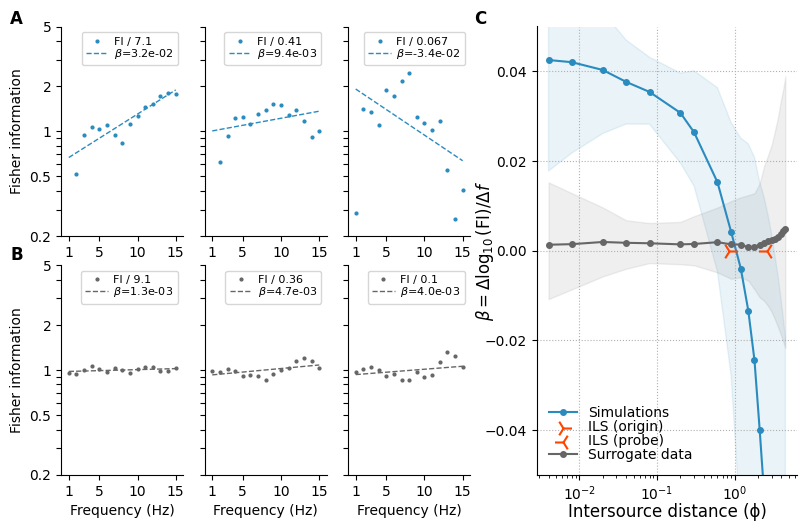

Wrote figs/kaiser16/1s/fit_k=True/reg_coefs_16Ts.pdf.


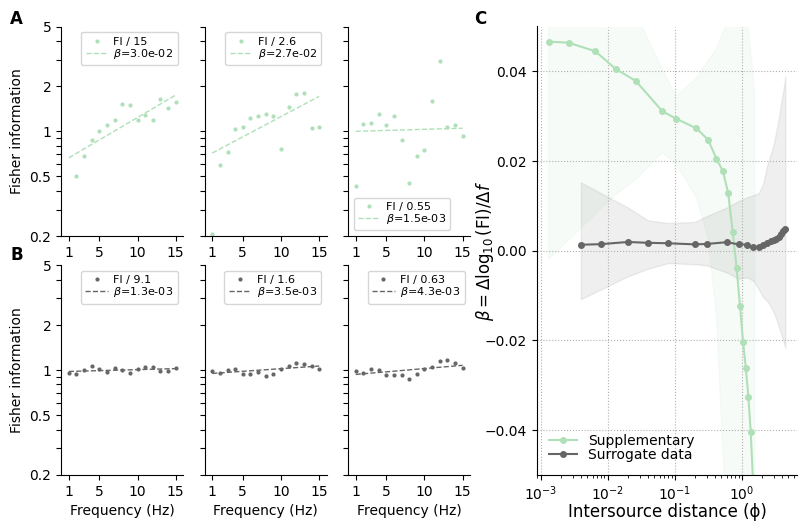

In [23]:
reload(fpf)
for ds in ["bw", "16Ts"]:
    which_ds = [ds,"s=p"]
    ax, ax_coef = fpf.plot_information_regression(data, which_ds, iprb, plot_ils = True)
    fpft.label_axes([ax[0][0], ax[1][0], ax_coef], "ABC",
                    fontsize=12, fontweight="bold",
                    align_x = [[0,1]],
                    align_y = [[0,2]])
    
    file_name = f"{fig_dir_full}/reg_coefs_{which_ds[0]}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()


# Information heatmaps as window size is changed

In [24]:
window_shapes_used  = lambda init_filter: sorted(list(set(m["compute"]["window_shape"] for m in proc.find_registry_matches(init_filter = init_filter, compute_filter={"fit_k":fit_k}))), 
                                                 key = lambda v: utils.remove_non_alphanum(str(v)))

In [25]:
[md.logger.setLevel(logging.WARNING) for md in [crick, boulder, surrogate, fp, proc]]

[None, None, None, None, None]

In [26]:
plot_series = False 
if plot_series:
    reload(fpf)
    heatmap_range = defaultdict(lambda: [-2, log10(500)], {"cr":[-2,2], "su_high_pink":[-2,2]})
    figsize       = defaultdict(lambda: (8,5), {"cr":(8,8)})
    for ds in data.keys():
        window_shapes = window_shapes_used(to_use[ds])
        if len(window_shapes)>1:
            for wnd_shp in window_shapes:
                series_data = {m["compute"]["window_length"]:FisherPlumes(d, load_sims=False) 
                               for d,m in zip(*proc.load_data(init_filter = to_use[ds], compute_filter={"fit_k":fit_k, "window_shape":wnd_shp}, return_matches=True))}
                fpf.plot_window_series(series_data, heatmap_range = heatmap_range[ds], figsize = figsize[ds])
                fig_dir = fpft.get_fig_dir(window_shape = wnd_shp, fit_k = fit_k, create = True)
                file_name = f"{fig_dir}/{ds}_series.pdf"
                SAVEPLOTS and (savefig(file_name, bbox_inches='tight', pad_inches=0), flush(f"Wrote {file_name}."));
                sys.stdout.flush(); plt.show()

# Compute the spectrum

In [27]:
Info = namedtuple('Info','name,color')
infos = {"16Ts": Info(name="Supp. dataset",               color = "dodgerblue"),
         "bw":   Info(name="Main dataset",                color = "orangered"),
         "s=p":  Info(name="Surrogate (all =, pink)",     color = "pink"),
         "shw":  Info(name="Surrogate (high>low, white)", color = "silver"),
         "shp":  Info(name="Surrogate (high>low, pink)",  color = "violet"),
}

Wrote figs/boxcar/1s/spectra.pdf.


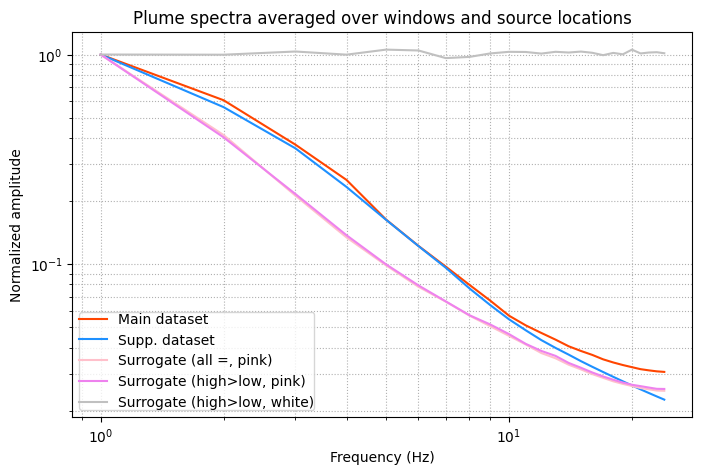

In [28]:
figure(figsize=(8,5))
for k in sorted(data, key=lambda x: infos[x].name):
    f = []
    for _, s in data[k].stft.items():
        fr, tt, S = s[0]
        f.append(np.abs(S))
        
    fs = F.fs.to("Hz").magnitude
    f = np.array(f)
    a = np.mean(f,axis=-1).mean(axis=0)    
    loglog(fr[fr<fs/2][1:],a[fr<fs/2][1:]/a[1],
           label=infos[k].name,
           color=infos[k].color)
legend(borderpad=0)
xlabel("Frequency (Hz)")
ylabel("Normalized amplitude")
title("Plume spectra averaged over windows and source locations")
grid(True, which='both', linestyle=":")
fig_dir = fpft.get_fig_dir(window_shape="boxcar", window_length=1*UNITS.s, create=True)
file_name = f"{fig_dir}/spectra.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));

# Velocity autocorrelation functions

Wrote figs/ils_supp.pdf.


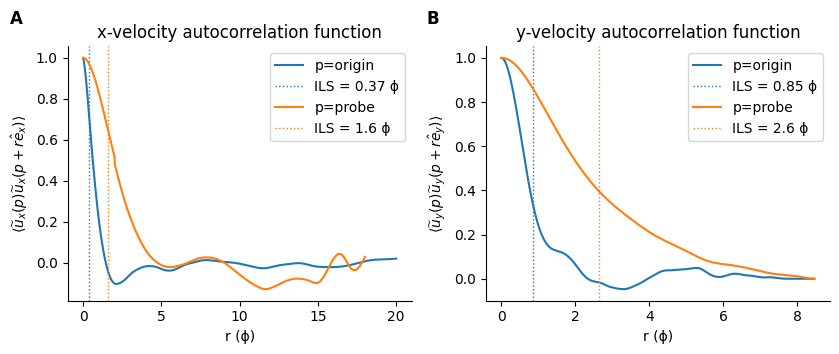

In [29]:
ils = data["bw"].sim0.integral_length_scales
keys = ils.keys()
figure(figsize=(8.5,3.5))
ax = []
for i, d in enumerate("xy"):
    ax.append(subplot(1,2,i+1))
    orig_key = (0 * UNITS.m, 0 * UNITS.m, d)
    probe_key = [k for k in keys if k[-1]==d and k!=orig_key][0]
    for j, (k, name) in enumerate(zip([orig_key,probe_key], ["origin", "probe"])):
        res   = ils[k]
        fr, l = res["fr"], res["l"]
        # l = nansum(fr) * ds
        ds = l / nansum(fr)
        xx = arange(len(fr))*ds.to(data["bw"].pitch).magnitude
        plot(xx, fr, label=f"p={name}")
        lmag = l.to(data["bw"].pitch).magnitude
        gca().axvline(lmag, color=f"C{j}", linewidth=1, linestyle=":", label = f"ILS = {lmag:.2} {fpf.pitch_sym}")
    legend()
    ylabel(f"$\langle \\widetilde u_{d}(p) \\widetilde u_{d}(p + r \hat e_{d}) \\rangle$")
    xlabel(f"r ({fpf.pitch_sym})")
    title(f"{d}-velocity autocorrelation function")
    fpft.spines_off(gca())
tight_layout()
fpft.label_axes(ax, "AB",
                    fontsize=12, fontweight="bold",
                    align_y = [[0,1]])
file_name = f"figs/ils_supp.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    

# The End

# Sandbox

## Plot λ for random frequencies

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)


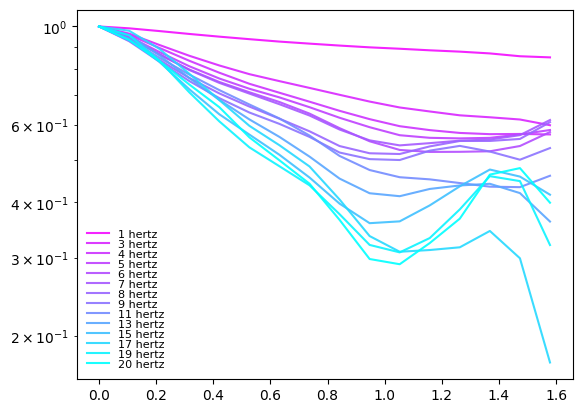

In [30]:
random.seed(1)
F = data["16Ts"]
d = np.array(list(F.la[0].keys()))/F.pitch.to(UNITS.um).magnitude
ibs = 0
la = np.array([F.la[0][ki][ibs] for ki in F.la[0]])
la1=la/la[0]
for i, f in zip(arange(la1.shape[1]), F.freqs):
    if f == 0 * UNITS.Hz: continue
    if f>20 * UNITS.Hz: break
    if rand()> 20/(len(F.freqs)*20/50): continue
    semilogy(d, la1[:, i], color = fpft.set_alpha(cm.cool_r(f/20 * UNITS.Hz),0.9), label = f"{f:g}");
#ylim(0.2,1)
legend(labelspacing=0, frameon=False, loc="lower left", fontsize=8)

# Manually run regressions

In [31]:
from sklearn.linear_model import LinearRegression, HuberRegressor
Regressor = LinearRegression()
Regressor = HuberRegressor(max_iter = 10000)

In [32]:
F         = data["bw"]
freq_min  = 1  * UNITS.Hz
freq_max  = 20 * UNITS.Hz
freqs     = F.freqs.to(UNITS.Hz).magnitude
n_bs, n_I_freq, n_d = F.I[0].shape  
ind       = (F.freqs >= freq_min) & (F.freqs <= freq_max)
reg_coefs = {}
lr        = Regressor
for j, Ibs in enumerate(F.I[0]):
    print(f"{j}", end=",")
    reg_coefs[j] = []
    for i in range(n_d):
        yy = Ibs[ind[:n_I_freq],i]
        xx = freqs[ind][:len(yy)]
        ivld = ~np.isnan(yy) & (yy>1e-15) & ~np.isinf(yy) 
        if len(ivld) - sum(ivld):
            pass
            print(f"Found {len(ivld) - sum(ivld)} out of range y values for ibs={j}, {i=}, d={F.I_dists[i]/F.pitch.to(UNITS.um).magnitude:.2f} ϕ")
        if len(ivld)>=5:
            lr.fit(xx[ivld].reshape(-1,1), np.log10(yy[ivld]))
            reg_coefs[j].append((xx,yy,ivld,[lr.intercept_] + list(lr.coef_)))
        else:
            reg_coefs[j].append((xx,yy,ivld,[np.nan]*2))          
            


0,Found 1 out of range y values for ibs=0, i=20, d=4.50 ϕ
1,

Found 1 out of range y values for ibs=1, i=20, d=4.50 ϕ
2,Found 1 out of range y values for ibs=2, i=5, d=0.20 ϕ
Found 1 out of range y values for ibs=2, i=6, d=0.30 ϕ
Found 1 out of range y values for ibs=2, i=7, d=0.60 ϕ
Found 1 out of range y values for ibs=2, i=8, d=0.90 ϕ
Found 2 out of range y values for ibs=2, i=9, d=1.20 ϕ
Found 3 out of range y values for ibs=2, i=10, d=1.50 ϕ
Found 4 out of range y values for ibs=2, i=11, d=1.80 ϕ
Found 4 out of range y values for ibs=2, i=12, d=2.10 ϕ
Found 4 out of range y values for ibs=2, i=13, d=2.40 ϕ
Found 4 out of range y values for ibs=2, i=14, d=2.70 ϕ
Found 5 out of range y values for ibs=2, i=15, d=3.00 ϕ
Found 6 out of range y values for ibs=2, i=16, d=3.30 ϕ
Found 6 out of range y values for ibs=2, i=17, d=3.60 ϕ
Found 7 out of range y values for ibs=2, i=18, d=3.90 ϕ
Found 8 out of range y values for ibs=2, i=19, d=4.20 ϕ
Found 8 out of range y values for ibs=2, i=20, d=4.50 ϕ
3,

4,5,Found 1 out of range y values for ibs=5, i=11, d=1.80 ϕ
Found 1 out of range y values for ibs=5, i=12, d=2.10 ϕ
Found 1 out of range y values for ibs=5, i=13, d=2.40 ϕ
Found 1 out of range y values for ibs=5, i=14, d=2.70 ϕ
Found 1 out of range y values for ibs=5, i=15, d=3.00 ϕ
Found 1 out of range y values for ibs=5, i=16, d=3.30 ϕ
Found 1 out of range y values for ibs=5, i=17, d=3.60 ϕ
Found 1 out of range y values for ibs=5, i=18, d=3.90 ϕ


Found 2 out of range y values for ibs=5, i=19, d=4.20 ϕ
Found 2 out of range y values for ibs=5, i=20, d=4.50 ϕ
6,Found 1 out of range y values for ibs=6, i=16, d=3.30 ϕ
Found 1 out of range y values for ibs=6, i=17, d=3.60 ϕ
Found 1 out of range y values for ibs=6, i=18, d=3.90 ϕ
Found 1 out of range y values for ibs=6, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=6, i=20, d=4.50 ϕ
7,Found 1 out of range y values for ibs=7, i=17, d=3.60 ϕ
Found 1 out of range y values for ibs=7, i=18, d=3.90 ϕ


Found 1 out of range y values for ibs=7, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=7, i=20, d=4.50 ϕ
8,9,

10,Found 1 out of range y values for ibs=10, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=10, i=20, d=4.50 ϕ
11,Found 1 out of range y values for ibs=11, i=13, d=2.40 ϕ
Found 1 out of range y values for ibs=11, i=14, d=2.70 ϕ
Found 2 out of range y values for ibs=11, i=15, d=3.00 ϕ
Found 2 out of range y values for ibs=11, i=16, d=3.30 ϕ
Found 2 out of range y values for ibs=11, i=17, d=3.60 ϕ
Found 2 out of range y values for ibs=11, i=18, d=3.90 ϕ


Found 2 out of range y values for ibs=11, i=19, d=4.20 ϕ
Found 3 out of range y values for ibs=11, i=20, d=4.50 ϕ
12,13,Found 1 out of range y values for ibs=13, i=5, d=0.20 ϕ
Found 1 out of range y values for ibs=13, i=6, d=0.30 ϕ
Found 1 out of range y values for ibs=13, i=7, d=0.60 ϕ
Found 1 out of range y values for ibs=13, i=8, d=0.90 ϕ
Found 1 out of range y values for ibs=13, i=9, d=1.20 ϕ
Found 1 out of range y values for ibs=13, i=10, d=1.50 ϕ
Found 2 out of range y values for ibs=13, i=11, d=1.80 ϕ
Found 2 out of range y values for ibs=13, i=12, d=2.10 ϕ
Found 3 out of range y values for ibs=13, i=13, d=2.40 ϕ
Found 4 out of range y values for ibs=13, i=14, d=2.70 ϕ
Found 4 out of range y values for ibs=13, i=15, d=3.00 ϕ


Found 5 out of range y values for ibs=13, i=16, d=3.30 ϕ
Found 6 out of range y values for ibs=13, i=17, d=3.60 ϕ
Found 7 out of range y values for ibs=13, i=18, d=3.90 ϕ
Found 7 out of range y values for ibs=13, i=19, d=4.20 ϕ
Found 7 out of range y values for ibs=13, i=20, d=4.50 ϕ
14,Found 1 out of range y values for ibs=14, i=9, d=1.20 ϕ
Found 1 out of range y values for ibs=14, i=10, d=1.50 ϕ
Found 1 out of range y values for ibs=14, i=11, d=1.80 ϕ
Found 1 out of range y values for ibs=14, i=12, d=2.10 ϕ
Found 3 out of range y values for ibs=14, i=13, d=2.40 ϕ
Found 4 out of range y values for ibs=14, i=14, d=2.70 ϕ
Found 5 out of range y values for ibs=14, i=15, d=3.00 ϕ
Found 6 out of range y values for ibs=14, i=16, d=3.30 ϕ
Found 6 out of range y values for ibs=14, i=17, d=3.60 ϕ
Found 6 out of range y values for ibs=14, i=18, d=3.90 ϕ
Found 7 out of range y values for ibs=14, i=19, d=4.20 ϕ
Found 7 out of range y values for ibs=14, i=20, d=4.50 ϕ
15,Found 1 out of range y val

Found 7 out of range y values for ibs=15, i=14, d=2.70 ϕ
Found 7 out of range y values for ibs=15, i=15, d=3.00 ϕ
Found 9 out of range y values for ibs=15, i=16, d=3.30 ϕ
Found 9 out of range y values for ibs=15, i=17, d=3.60 ϕ
Found 9 out of range y values for ibs=15, i=18, d=3.90 ϕ
Found 9 out of range y values for ibs=15, i=19, d=4.20 ϕ
Found 9 out of range y values for ibs=15, i=20, d=4.50 ϕ
16,Found 1 out of range y values for ibs=16, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=16, i=20, d=4.50 ϕ
17,

Found 1 out of range y values for ibs=17, i=16, d=3.30 ϕ
Found 2 out of range y values for ibs=17, i=17, d=3.60 ϕ
Found 2 out of range y values for ibs=17, i=18, d=3.90 ϕ
Found 2 out of range y values for ibs=17, i=19, d=4.20 ϕ
Found 2 out of range y values for ibs=17, i=20, d=4.50 ϕ
18,19,

20,21,

Found 1 out of range y values for ibs=21, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=21, i=20, d=4.50 ϕ
22,Found 1 out of range y values for ibs=22, i=8, d=0.90 ϕ
Found 1 out of range y values for ibs=22, i=9, d=1.20 ϕ
Found 1 out of range y values for ibs=22, i=10, d=1.50 ϕ
Found 2 out of range y values for ibs=22, i=11, d=1.80 ϕ
Found 2 out of range y values for ibs=22, i=12, d=2.10 ϕ
Found 3 out of range y values for ibs=22, i=13, d=2.40 ϕ
Found 3 out of range y values for ibs=22, i=14, d=2.70 ϕ
Found 3 out of range y values for ibs=22, i=15, d=3.00 ϕ
Found 5 out of range y values for ibs=22, i=16, d=3.30 ϕ
Found 5 out of range y values for ibs=22, i=17, d=3.60 ϕ
Found 5 out of range y values for ibs=22, i=18, d=3.90 ϕ
Found 5 out of range y values for ibs=22, i=19, d=4.20 ϕ
Found 6 out of range y values for ibs=22, i=20, d=4.50 ϕ
23,Found 2 out of range y values for ibs=23, i=16, d=3.30 ϕ
Found 2 out of range y values for ibs=23, i=17, d=3.60 ϕ


Found 2 out of range y values for ibs=23, i=18, d=3.90 ϕ
Found 2 out of range y values for ibs=23, i=19, d=4.20 ϕ
Found 3 out of range y values for ibs=23, i=20, d=4.50 ϕ
24,Found 1 out of range y values for ibs=24, i=18, d=3.90 ϕ
Found 1 out of range y values for ibs=24, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=24, i=20, d=4.50 ϕ
25,Found 1 out of range y values for ibs=25, i=12, d=2.10 ϕ
Found 1 out of range y values for ibs=25, i=13, d=2.40 ϕ


Found 1 out of range y values for ibs=25, i=14, d=2.70 ϕ
Found 2 out of range y values for ibs=25, i=15, d=3.00 ϕ
Found 3 out of range y values for ibs=25, i=16, d=3.30 ϕ
Found 3 out of range y values for ibs=25, i=17, d=3.60 ϕ
Found 3 out of range y values for ibs=25, i=18, d=3.90 ϕ
Found 3 out of range y values for ibs=25, i=19, d=4.20 ϕ
Found 4 out of range y values for ibs=25, i=20, d=4.50 ϕ
26,Found 1 out of range y values for ibs=26, i=14, d=2.70 ϕ
Found 1 out of range y values for ibs=26, i=15, d=3.00 ϕ
Found 2 out of range y values for ibs=26, i=16, d=3.30 ϕ
Found 3 out of range y values for ibs=26, i=17, d=3.60 ϕ
Found 4 out of range y values for ibs=26, i=18, d=3.90 ϕ
Found 4 out of range y values for ibs=26, i=19, d=4.20 ϕ
Found 4 out of range y values for ibs=26, i=20, d=4.50 ϕ
27,Found 1 out of range y values for ibs=27, i=5, d=0.20 ϕ
Found 2 out of range y values for ibs=27, i=6, d=0.30 ϕ
Found 3 out of range y values for ibs=27, i=7, d=0.60 ϕ
Found 5 out of range y value

Found 6 out of range y values for ibs=27, i=11, d=1.80 ϕ
Found 6 out of range y values for ibs=27, i=12, d=2.10 ϕ
Found 7 out of range y values for ibs=27, i=13, d=2.40 ϕ
Found 7 out of range y values for ibs=27, i=14, d=2.70 ϕ
Found 7 out of range y values for ibs=27, i=15, d=3.00 ϕ
Found 8 out of range y values for ibs=27, i=16, d=3.30 ϕ
Found 8 out of range y values for ibs=27, i=17, d=3.60 ϕ
Found 8 out of range y values for ibs=27, i=18, d=3.90 ϕ
Found 8 out of range y values for ibs=27, i=19, d=4.20 ϕ
Found 8 out of range y values for ibs=27, i=20, d=4.50 ϕ
28,29,Found 1 out of range y values for ibs=29, i=4, d=0.08 ϕ
Found 1 out of range y values for ibs=29, i=5, d=0.20 ϕ
Found 1 out of range y values for ibs=29, i=6, d=0.30 ϕ
Found 2 out of range y values for ibs=29, i=7, d=0.60 ϕ
Found 3 out of range y values for ibs=29, i=8, d=0.90 ϕ


Found 3 out of range y values for ibs=29, i=9, d=1.20 ϕ
Found 3 out of range y values for ibs=29, i=10, d=1.50 ϕ
Found 4 out of range y values for ibs=29, i=11, d=1.80 ϕ
Found 7 out of range y values for ibs=29, i=12, d=2.10 ϕ
Found 7 out of range y values for ibs=29, i=13, d=2.40 ϕ
Found 7 out of range y values for ibs=29, i=14, d=2.70 ϕ
Found 7 out of range y values for ibs=29, i=15, d=3.00 ϕ
Found 7 out of range y values for ibs=29, i=16, d=3.30 ϕ
Found 7 out of range y values for ibs=29, i=17, d=3.60 ϕ
Found 7 out of range y values for ibs=29, i=18, d=3.90 ϕ
Found 10 out of range y values for ibs=29, i=19, d=4.20 ϕ
Found 13 out of range y values for ibs=29, i=20, d=4.50 ϕ
30,31,

32,33,

34,Found 1 out of range y values for ibs=34, i=13, d=2.40 ϕ
Found 1 out of range y values for ibs=34, i=14, d=2.70 ϕ
Found 1 out of range y values for ibs=34, i=15, d=3.00 ϕ
Found 1 out of range y values for ibs=34, i=16, d=3.30 ϕ
Found 1 out of range y values for ibs=34, i=17, d=3.60 ϕ
Found 1 out of range y values for ibs=34, i=18, d=3.90 ϕ
Found 1 out of range y values for ibs=34, i=19, d=4.20 ϕ
Found 2 out of range y values for ibs=34, i=20, d=4.50 ϕ
35,Found 1 out of range y values for ibs=35, i=5, d=0.20 ϕ
Found 1 out of range y values for ibs=35, i=6, d=0.30 ϕ
Found 1 out of range y values for ibs=35, i=7, d=0.60 ϕ
Found 1 out of range y values for ibs=35, i=8, d=0.90 ϕ
Found 1 out of range y values for ibs=35, i=9, d=1.20 ϕ
Found 1 out of range y values for ibs=35, i=10, d=1.50 ϕ
Found 2 out of range y values for ibs=35, i=11, d=1.80 ϕ
Found 4 out of range y values for ibs=35, i=12, d=2.10 ϕ
Found 4 out of range y values for ibs=35, i=13, d=2.40 ϕ
Found 5 out of range y values 

Found 8 out of range y values for ibs=35, i=17, d=3.60 ϕ
Found 9 out of range y values for ibs=35, i=18, d=3.90 ϕ
Found 9 out of range y values for ibs=35, i=19, d=4.20 ϕ
Found 10 out of range y values for ibs=35, i=20, d=4.50 ϕ
36,Found 1 out of range y values for ibs=36, i=11, d=1.80 ϕ
Found 2 out of range y values for ibs=36, i=12, d=2.10 ϕ
Found 2 out of range y values for ibs=36, i=13, d=2.40 ϕ
Found 2 out of range y values for ibs=36, i=14, d=2.70 ϕ
Found 2 out of range y values for ibs=36, i=15, d=3.00 ϕ
Found 2 out of range y values for ibs=36, i=16, d=3.30 ϕ
Found 2 out of range y values for ibs=36, i=17, d=3.60 ϕ
Found 3 out of range y values for ibs=36, i=18, d=3.90 ϕ
Found 4 out of range y values for ibs=36, i=19, d=4.20 ϕ
Found 4 out of range y values for ibs=36, i=20, d=4.50 ϕ
37,Found 1 out of range y values for ibs=37, i=10, d=1.50 ϕ
Found 1 out of range y values for ibs=37, i=11, d=1.80 ϕ
Found 1 out of range y values for ibs=37, i=12, d=2.10 ϕ
Found 1 out of range y v

Found 1 out of range y values for ibs=37, i=14, d=2.70 ϕ
Found 1 out of range y values for ibs=37, i=15, d=3.00 ϕ
Found 1 out of range y values for ibs=37, i=16, d=3.30 ϕ
Found 1 out of range y values for ibs=37, i=17, d=3.60 ϕ
Found 2 out of range y values for ibs=37, i=18, d=3.90 ϕ
Found 2 out of range y values for ibs=37, i=19, d=4.20 ϕ
Found 2 out of range y values for ibs=37, i=20, d=4.50 ϕ
38,Found 1 out of range y values for ibs=38, i=4, d=0.08 ϕ
Found 1 out of range y values for ibs=38, i=5, d=0.20 ϕ
Found 1 out of range y values for ibs=38, i=6, d=0.30 ϕ
Found 1 out of range y values for ibs=38, i=7, d=0.60 ϕ
Found 1 out of range y values for ibs=38, i=8, d=0.90 ϕ
Found 1 out of range y values for ibs=38, i=9, d=1.20 ϕ
Found 1 out of range y values for ibs=38, i=10, d=1.50 ϕ
Found 1 out of range y values for ibs=38, i=11, d=1.80 ϕ
Found 1 out of range y values for ibs=38, i=12, d=2.10 ϕ
Found 1 out of range y values for ibs=38, i=13, d=2.40 ϕ
Found 1 out of range y values for 

Found 2 out of range y values for ibs=39, i=11, d=1.80 ϕ
Found 5 out of range y values for ibs=39, i=12, d=2.10 ϕ
Found 5 out of range y values for ibs=39, i=13, d=2.40 ϕ
Found 5 out of range y values for ibs=39, i=14, d=2.70 ϕ
Found 7 out of range y values for ibs=39, i=15, d=3.00 ϕ
Found 8 out of range y values for ibs=39, i=16, d=3.30 ϕ
Found 10 out of range y values for ibs=39, i=17, d=3.60 ϕ
Found 10 out of range y values for ibs=39, i=18, d=3.90 ϕ
Found 10 out of range y values for ibs=39, i=19, d=4.20 ϕ
Found 12 out of range y values for ibs=39, i=20, d=4.50 ϕ
40,Found 1 out of range y values for ibs=40, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=40, i=20, d=4.50 ϕ
41,

Found 1 out of range y values for ibs=41, i=14, d=2.70 ϕ
Found 1 out of range y values for ibs=41, i=15, d=3.00 ϕ
Found 1 out of range y values for ibs=41, i=16, d=3.30 ϕ
Found 1 out of range y values for ibs=41, i=17, d=3.60 ϕ
Found 2 out of range y values for ibs=41, i=18, d=3.90 ϕ
Found 2 out of range y values for ibs=41, i=19, d=4.20 ϕ
Found 2 out of range y values for ibs=41, i=20, d=4.50 ϕ
42,43,

44,45,Found 1 out of range y values for ibs=45, i=20, d=4.50 ϕ


46,Found 1 out of range y values for ibs=46, i=20, d=4.50 ϕ
47,Found 1 out of range y values for ibs=47, i=12, d=2.10 ϕ
Found 1 out of range y values for ibs=47, i=13, d=2.40 ϕ
Found 1 out of range y values for ibs=47, i=14, d=2.70 ϕ
Found 2 out of range y values for ibs=47, i=15, d=3.00 ϕ
Found 3 out of range y values for ibs=47, i=16, d=3.30 ϕ
Found 3 out of range y values for ibs=47, i=17, d=3.60 ϕ
Found 3 out of range y values for ibs=47, i=18, d=3.90 ϕ


Found 4 out of range y values for ibs=47, i=19, d=4.20 ϕ
Found 5 out of range y values for ibs=47, i=20, d=4.50 ϕ
48,49,

Found 1 out of range y values for ibs=49, i=20, d=4.50 ϕ
50,Found 1 out of range y values for ibs=50, i=12, d=2.10 ϕ
Found 1 out of range y values for ibs=50, i=13, d=2.40 ϕ
Found 1 out of range y values for ibs=50, i=14, d=2.70 ϕ
Found 1 out of range y values for ibs=50, i=15, d=3.00 ϕ
Found 1 out of range y values for ibs=50, i=16, d=3.30 ϕ
Found 1 out of range y values for ibs=50, i=17, d=3.60 ϕ
Found 1 out of range y values for ibs=50, i=18, d=3.90 ϕ
Found 1 out of range y values for ibs=50, i=19, d=4.20 ϕ
Found 1 out of range y values for ibs=50, i=20, d=4.50 ϕ


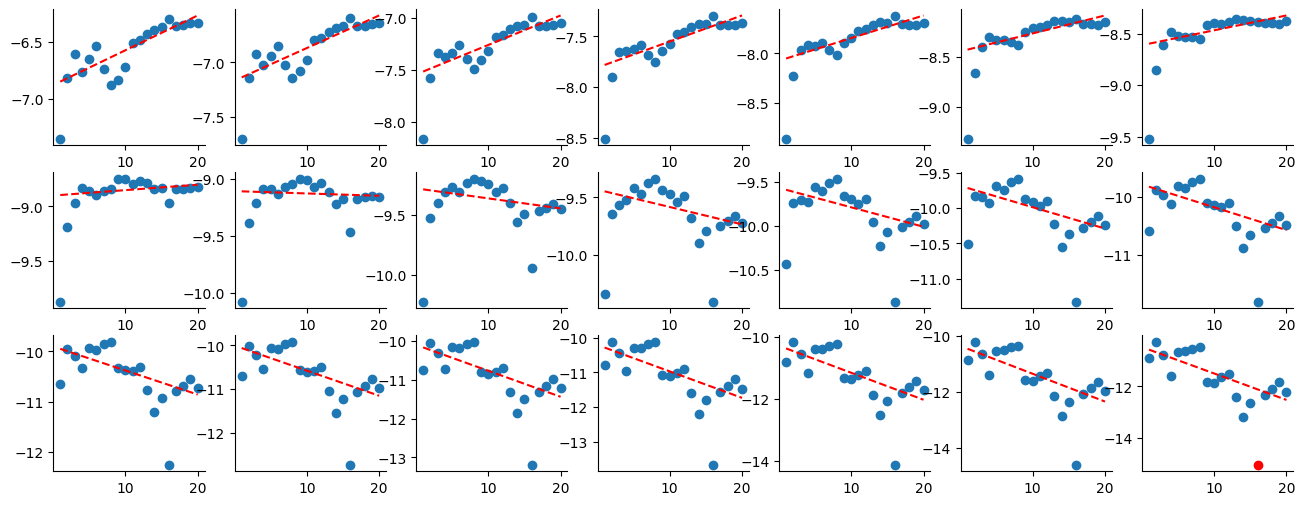

In [33]:
which_ibs = 0
figure(figsize=(16,6))
for i in range(n_d):
    xx, yy, ivld, coefs = reg_coefs[which_ibs][i]
    if not np.isnan(coefs[0]):
        lr.intercept_ = coefs[0]
        lr.coef_      = np.array(coefs[1:])
        logye         = lr.predict(np.array(xx[ivld]).reshape(-1,1))
    subplot(3,7,i+1)
    scatter(xx[ivld], log10(yy[ivld]))
    scatter(xx[~ivld], log10(yy[~ivld]), c="r")
    plot(xx[ivld], logye,"r--")
    fpft.spines_off(gca())
    #gca().set_xticks([])
    #gca().set_yticks([])
    
    